In [166]:
# !pip install --upgrade pip

import os
from joblib import Parallel, delayed

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dataclasses
from sklearn.svm import OneClassSVM
from dataclasses import asdict
from tqdm import tqdm
import warnings
import random
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold # Feature selector

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns


# Global utitlity functions are in separate notebook
%run ./Classification_utility-functions.ipynb
%run ./SEED-CONSTANTS.ipynb

np.random.seed(SEED)
print(f"Numpy Seed was set to: {SEED}")

print("Setup Complete")

SEED: 567
--------------------SEED and CONSTANTS imported--------------------
SEED: 567
Python 3.9.10
EER: 0.333, Threshold: 0.600 <-- Arbitrary case
EER: 0.000, Threshold: 0.900 <-- Best case
EER: 1.000, Threshold: 0.900 <-- Worse case
EER: 0.400, Threshold: 0.200 <-- Worse case
EER: 0.167, Threshold: 0.600 <-- Arbitrary case
EER: 0.000, Threshold: 0.900 <-- Best case
EER: 1.000, Threshold: 0.900 <-- Worse case
EER: 0.333, Threshold: 1.000 <-- Worse case
--------------------Utility functions imported--------------------
SEED: 567
--------------------SEED and CONSTANTS imported--------------------
SEED: 567
Python 3.9.10
--------------------Preprocessing utility functions imported--------------------
SEED: 567
--------------------SEED and CONSTANTS imported--------------------
SEED: 567
Python 3.9.10
--------------------Neural Networks utility functions imported--------------------
SEED: 567
--------------------SEED and CONSTANTS imported--------------------
SEED: 567
Python 3.9.10
EER

In [2]:
@dataclasses.dataclass
class ExperimentParameters:
    """Contains all relevant parameters to run an experiment."""

    name: str  # Name of Parameter set. Used as identifier for charts etc.
    frequency: int
    max_subjects: int
    max_test_subjects: int
        
    user_ids: list
    num_sample_points_per_exp: int
    exp_begin_cutoff_idx: int
    exp_end_cutoff_idx: int
        
    
    seconds_per_subject_train: float
    seconds_per_subject_test: float
    window_size: int  # After resampling
    ocsvm_step_width: int  # After resampling
    scaler: str  # StandardScaler, MinMaxScaler, Normalizer, MaxAbsScaler, RobustScaler, PowerTransformer
    scaler_scope: str  # {"subject", "session"}
    scaler_global: bool  # fit transform scale on all data (True) or fit on training only (False)
    ocsvm_kernel: str # ocsvm kernel
    ocsvm_nu: float  # Best value found in random search, used for final model
    ocsvm_gamma: float  # Best value found in random search, used for final model
    feature_cols: list  # Columns used as features
    exclude_subjects: list  # Don't load data from those users
        
    # Calculated values
    def __post_init__(self):
        # HDF key of table:
        self.table_name = f"sensors_{self.frequency}hz"

        

# INSTANCES
# ===========================================================

# NAIVE_APPROACH
# -----------------------------------------------------------
NAIVE_MINMAX_OCSVM = ExperimentParameters(
    name="NAIVE-MINMAX_OCSVM",
    frequency=100,
    max_subjects=29,
    max_test_subjects=10,
    user_ids = [1, 2, 3, 4, 5, 6, 7, 8, 19, 21, 22, 26, 27, 28, 29, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49],
    num_sample_points_per_exp=21000,
    exp_begin_cutoff_idx=500,
    exp_end_cutoff_idx=-500,
    seconds_per_subject_train=210,
    seconds_per_subject_test=210,    
    window_size=250,
    ocsvm_step_width=250,
    scaler="minmax",
    scaler_scope="subject",
    scaler_global=True,
    ocsvm_kernel="rbf",
    ocsvm_nu=None,
    ocsvm_gamma=None,
    feature_cols=[
        "x_a",
        "y_a",
        "z_a",
        "x_g",
        "y_g",
        "z_g",
    ],
    exclude_subjects=[],
)

# VALID_APPROACH
# -----------------------------------------------------------
VALID_MINMAX_OCSVM = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-MINMAX-OCSVM",
    scaler_global=False,
    ocsvm_nu=0.165,
    ocsvm_gamma=0.039,
)

# NAIVE_ROBUST_APPROACH
# -----------------------------------------------------------
NAIVE_ROBUST_OCSVM = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="NAIVE-ROBUST-OCSVM",
    scaler="robust",
    scaler_global=True,
    ocsvm_nu=0.153,
    ocsvm_gamma=0.091,  # below median, selected by chart
)

# ROBUST_APPROACH (VALID)
# -----------------------------------------------------------
VALID_ROBUST_OCSVM_125 = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-ROBUST-OCSVM",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=125
#     ocsvm_nu=0.037,
#     ocsvm_gamma= 0.001,
)


VALID_ROBUST_OCSVM_250 = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-ROBUST-OCSVM",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=250
#     ocsvm_nu=0.037,
#     ocsvm_gamma= 0.001,
)

VALID_ROBUST_OCSVM_500 = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-ROBUST-OCSVM",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=500
#     ocsvm_nu=0.037,
#     ocsvm_gamma= 0.001,
)

VALID_ROBUST_OCSVM_750 = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-ROBUST-OCSVM",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=750
#     ocsvm_nu=0.037,
#     ocsvm_gamma= 0.001,
)

VALID_ROBUST_OCSVM_1000 = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-ROBUST-OCSVM",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=1000
#     ocsvm_nu=0.037,
#     ocsvm_gamma= 0.001,
)

VALID_ROBUST_OCSVM_1250 = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-ROBUST-OCSVM",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=1250
#     ocsvm_nu=0.037,
#     ocsvm_gamma= 0.001,
)

VALID_ROBUST_OCSVM_1500 = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-ROBUST-OCSVM",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=1500
#     ocsvm_nu=0.037,
#     ocsvm_gamma= 0.001,
)

VALID_ROBUST_OCSVM_1750 = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-ROBUST-OCSVM",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=1750
#     ocsvm_nu=0.037,
#     ocsvm_gamma= 0.001,
)

VALID_ROBUST_OCSVM_2000 = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-ROBUST-OCSVM",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=2000
#     ocsvm_nu=0.037,
#     ocsvm_gamma= 0.001,
)

# NORMALIZER_APPROACH (VALID)
# -----------------------------------------------------------
VALID_NORMALIZER_OCSVM = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-NORMALIZER-OCSVM",
    scaler="Normalizer",
    scaler_global=False,
    ocsvm_nu=0.074,
    ocsvm_gamma= 0.029,
)

In [3]:
P = VALID_ROBUST_OCSVM_2000
P.ocsvm_step_width = int(P.window_size * .5)
P.classifier="OCSVM"
# P = VALID_NORMALIZER_OCSVM

In [4]:
utils_ppp(P)

,Value
name,VALID-ROBUST-OCSVM
frequency,100
max_subjects,29
max_test_subjects,10
user_ids,"[1, 2, 3, 4, 5, 6, 7, 8, 19, 21, 22, 26, 27, 2..."
num_sample_points_per_exp,21000
exp_begin_cutoff_idx,500
exp_end_cutoff_idx,-500
seconds_per_subject_train,210
seconds_per_subject_test,210


In [5]:
[1, 2, 3, 4, 5, 6, 7, 8, 19, 21, 22, 26, 27, 28, 29, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49][17]

37

In [6]:
utils_eer_scorer

make_scorer(utils_eer, greater_is_better=False)

# Split Dataset for Valid/Test  
In two splits: one used during hyperparameter optimization, and one used during testing.

The split is done along the subjects: All sessions of a single subject will either be in the validation split or in the testing split, never in both.

They did a 30 60 split.

# Reshaping Raw Features.
We have our own function of windows for this. Do this for both training and testing.

# Extracting time and frequency based features.
Again, we have a function for this. Do this for both training and testing.

# Hyperparameter Optimization 

I do not find any reaqsonable explaination how to use a cross-validation as we are talking about anomaly detection.

I am using the experiment 1 data as train, and experiment 2 data as validation.

# Using SVM in a real-world Scenario with multiple genuine users and intruders
Source: https://datascience.stackexchange.com/questions/23623/what-is-the-best-way-to-classify-data-not-belonging-to-set-of-classes

Stage 1: 
    Use one-class SVM to assign those images that do not belong to the set of predefined classes as the 9-th class.

Stage 2:
    For those images that passes through your filter, let the multi-class SVM assign them to one of the 8 classes.

Loading data:

In [7]:
P.user_ids

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 19,
 21,
 22,
 26,
 27,
 28,
 29,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 48,
 49]

In [8]:
#include 47 later
# user_ids = [9]
df_exps_dict = load_data_frames(P.user_ids, P.exp_begin_cutoff_idx, P.exp_end_cutoff_idx, P.num_sample_points_per_exp)
dfList_exp1, dfList_exp2 = df_exps_dict['dfList_exp1'], df_exps_dict['dfList_exp2']

Loading exp1 data:
1) accel_count: 28388, gyro_count: 31997
2) accel_count: 26010, gyro_count: 28954
3) accel_count: 28227, gyro_count: 31814
4) accel_count: 24860, gyro_count: 26105
5) accel_count: 24270, gyro_count: 24347
6) accel_count: 25012, gyro_count: 25060
7) accel_count: 25301, gyro_count: 25382
8) accel_count: 21975, gyro_count: 21658
19) accel_count: 24110, gyro_count: 25050
21) accel_count: 24326, gyro_count: 23809
22) accel_count: 29123, gyro_count: 28724
26) accel_count: 23148, gyro_count: 24291
27) accel_count: 24299, gyro_count: 23589
28) accel_count: 23807, gyro_count: 24523
29) accel_count: 24030, gyro_count: 23457
35) accel_count: 24388, gyro_count: 23673
36) accel_count: 24228, gyro_count: 24208
37) accel_count: 31945, gyro_count: 31816
38) accel_count: 22135, gyro_count: 22327
39) accel_count: 23573, gyro_count: 23459
40) accel_count: 23057, gyro_count: 24296
41) accel_count: 24102, gyro_count: 23681
42) accel_count: 24074, gyro_count: 24328
43) accel_count: 22631,

In [9]:
raw_dfList_exp1 = dfList_exp1
raw_dfList_exp2 = dfList_exp2

<AxesSubplot:>

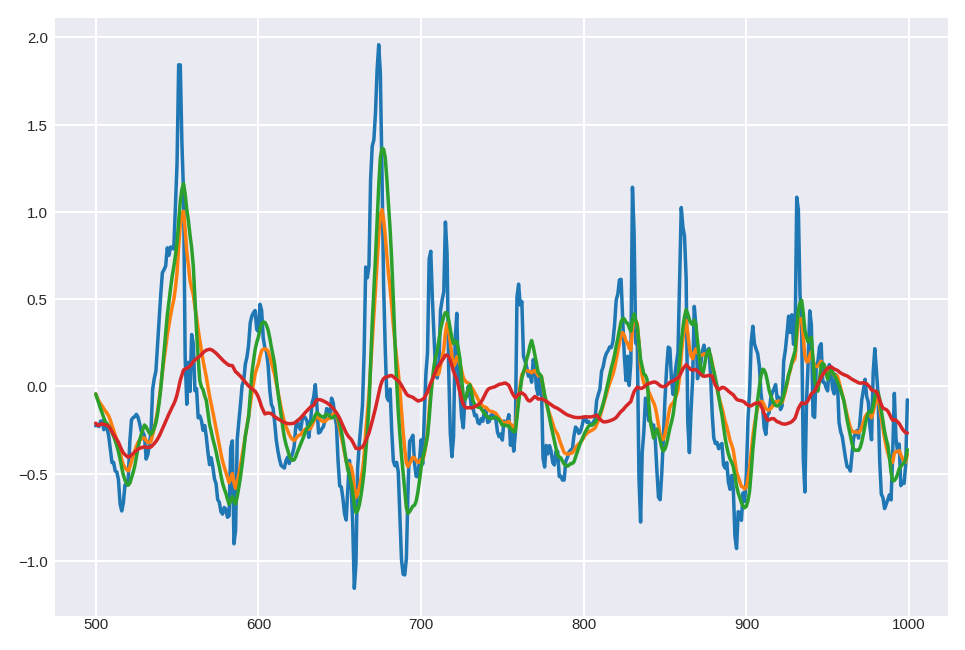

In [10]:
P.span=15
P.smoothing = "FFT+EMA"
# raw_dfList_exp1 = dfList_exp1
# raw_dfList_exp2 = dfList_exp2
P.cut_off_freq=42
ffted_dfList_exp1 = get_ffted_dfList(raw_dfList_exp1, cut_off_freq=P.cut_off_freq, filter_order=10)
ffted_dfList_exp2 = get_ffted_dfList(raw_dfList_exp2, cut_off_freq=P.cut_off_freq, filter_order=10)
ffted_dfList_exp2[0]['x_a'][500:1000].plot()
EMAed_dfList_exp1 = get_EMAed_dfList(ffted_dfList_exp1, span=P.span)
EMAed_dfList_exp2 = get_EMAed_dfList(ffted_dfList_exp2, span=P.span)
EMAed_dfList_exp2[0]['x_a'][500:1000].plot()

dfList_exp1 = ffted_dfList_exp1
dfList_exp2 = ffted_dfList_exp2

dfList_exp1 =EMAed_dfList_exp1
dfList_exp2 =EMAed_dfList_exp2

SMAed_dfList_exp1 = get_SMAed_dfList(ffted_dfList_exp1, winsize=10)
SMAed_dfList_exp2 = get_SMAed_dfList(ffted_dfList_exp2, winsize=10)
SMAed_dfList_exp2[0]['x_a'][500:1000].plot()

raw_dfList_exp2[0]['x_a'][500:1000].rolling(window=50, min_periods=0).mean().plot()

In [11]:
randomized_data_idx = list(range(len(P.user_ids)))
random.Random(SEED).shuffle(randomized_data_idx)
split_idx = 2 * (len(randomized_data_idx)//3) + 1
train_set = randomized_data_idx[: split_idx]
test_set = randomized_data_idx[split_idx: ]
print(f"train_set: {train_set}\ntest_set: {test_set}")

train_set: [7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6, 25, 16, 1, 17, 27, 5]
test_set: [0, 12, 14, 9, 18, 23, 2, 15, 10, 4]


Loading exp1 data:
47) accel_count: 22777, gyro_count: 22226
Loading exp2 data:
47) accel_count: 17718, gyro_count: 18353


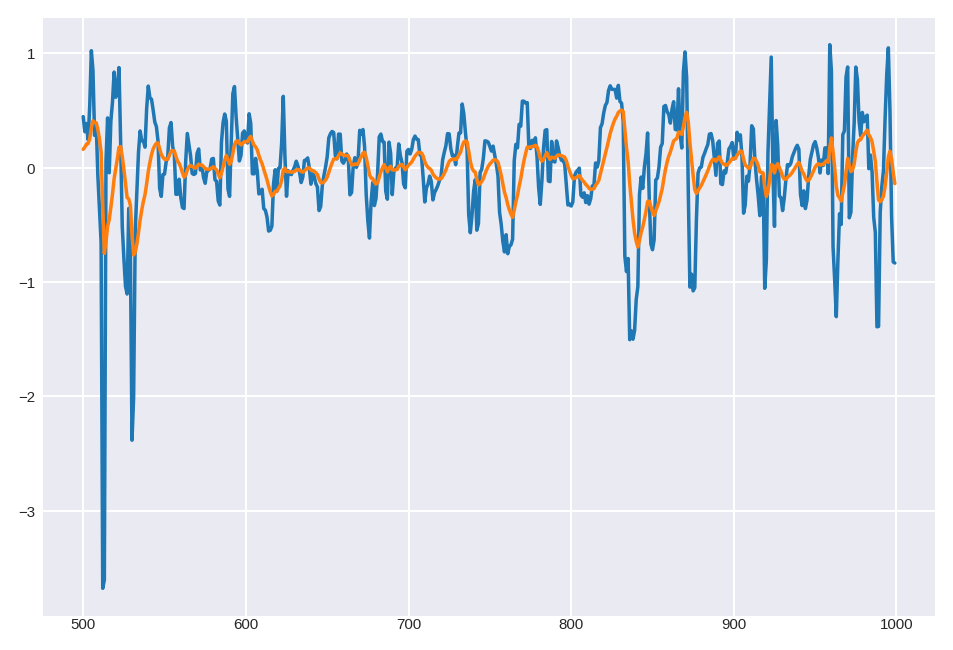

SEED: 567
--------------------SEED and CONSTANTS imported--------------------
SEED: 567
Python 3.9.10
EER: 0.333, Threshold: 0.600 <-- Arbitrary case
EER: 0.000, Threshold: 0.900 <-- Best case
EER: 1.000, Threshold: 0.900 <-- Worse case
EER: 0.400, Threshold: 0.200 <-- Worse case
EER: 0.167, Threshold: 0.600 <-- Arbitrary case
EER: 0.000, Threshold: 0.900 <-- Best case
EER: 1.000, Threshold: 0.900 <-- Worse case
EER: 0.333, Threshold: 1.000 <-- Worse case
--------------------Utility functions imported--------------------
len(exp1_df_user_set_dict): 19
len(exp2_df_user_set_dict): 19
len(X_exp1_dict_user_47[47]): 20
len_exp2_user_47: 17
user_47_idx: 29
np.unique(all_user_set): [ 1  2  3  4  5  6  7  8 19 21 22 26 27 28 29 35 36 37 38 39 40 41 42 43
 44 45 46 48 49]
X_exp1_dict.keys(): dict_keys([7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6, 25, 16, 1, 17, 27, 5, 29])
X_exp2_dict.keys(): dict_keys([7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6, 25, 16, 1, 17, 27, 5, 29])
fitted_scaler_

In [12]:
num_sample_points_per_exp_user_47 = 18000
df_exps_dict_user_47 = load_data_frames([47], P.exp_begin_cutoff_idx, P.exp_end_cutoff_idx, num_sample_points_per_exp_user_47)
dfList_exp1_user_47, dfList_exp2_user_47 = df_exps_dict_user_47['dfList_exp1'], df_exps_dict_user_47['dfList_exp2']

raw_dfList_exp1_user_47 = dfList_exp1_user_47
raw_dfList_exp2_user_47 = dfList_exp2_user_47

ffted_dfList_exp1_user_47 = get_ffted_dfList(raw_dfList_exp1_user_47, cut_off_freq=P.cut_off_freq, filter_order=10, filtfilt=1)
ffted_dfList_exp2_user_47 = get_ffted_dfList(raw_dfList_exp2_user_47, cut_off_freq=P.cut_off_freq, filter_order=10, filtfilt=1)
ffted_dfList_exp2_user_47[0]['x_a'][500:1000].plot()

dfList_exp1_user_47 = ffted_dfList_exp1_user_47
dfList_exp2_user_47 = ffted_dfList_exp2_user_47

EMAed_dfList_exp1_user_47 = get_EMAed_dfList(ffted_dfList_exp1_user_47, span=P.span)
EMAed_dfList_exp2_user_47 = get_EMAed_dfList(ffted_dfList_exp2_user_47, span=P.span)
EMAed_dfList_exp2_user_47[0]['x_a'][500:1000].plot()

dfList_exp1_user_47 = EMAed_dfList_exp1_user_47
dfList_exp2_user_47 = EMAed_dfList_exp2_user_47

%run ./utility-functions.ipynb


# preparing train data
X_train_exp1_dict, X_train_exp2_dict, fitted_scaler_train_exp2_dict=get_raw_windows(dfList_exp1, dfList_exp2, P.window_size, P.ocsvm_step_width, train_set, 
                                                                    P.scaler, P.num_sample_points_per_exp, EMA_per_win_span=None, SMA_per_win_winsize=None)

X_train_exp1_dict_user_47, X_train_exp2_dict_user_47, fitted_scaler_train_exp2_dict_user_47=get_raw_windows_user_47(dfList_exp1_user_47, dfList_exp2_user_47, P.window_size, P.ocsvm_step_width, 
                                                                                                                    scaler=P.scaler, num_sample_points_per_exp=P.num_sample_points_per_exp, 
                                                                                                                    EMA_per_win_span=None, SMA_per_win_winsize=None)

X_train_exp1_dict, X_train_exp2_dict, fitted_scaler_train_exp2_dict=append_user_47_to_data(X_train_exp1_dict, X_train_exp2_dict, fitted_scaler_train_exp2_dict, P.user_ids, 
                                                                                           X_train_exp1_dict_user_47, X_train_exp2_dict_user_47, fitted_scaler_train_exp2_dict_user_47, verbose=1)

print(f"len(exp1_df_train_dict): {len(X_train_exp1_dict)}")
print(f"len(exp2_df_train_dict): {len(X_train_exp2_dict)}")


# preparing test data
X_test_exp1_dict, X_test_exp2_dict, fitted_scaler_test_exp2_dict=get_raw_windows(dfList_exp1, dfList_exp2, P.window_size, P.ocsvm_step_width, test_set, 
                                                                    P.scaler, P.num_sample_points_per_exp, EMA_per_win_span=None, SMA_per_win_winsize=None)

print(f"len(X_test_exp1_dict): {len(X_test_exp1_dict)}")
print(f"len(X_test_exp2_dict): {len(X_test_exp2_dict)}")

In [143]:
P.Butter_per_win_argdict={
                        "filter_order": 10,
                        "cut_off_freq": 27,
                        "sampling_freq": 100,
                        "filtfilt": 1,
                        }
P.Butter_per_win_argdict=None
EMA_per_win_span=None
SMA_per_win_winsize=None
fitted_scaler_train_exp2_dict_user_47
fitted_scaler_train_exp2_dict


overlap=.5
window_size=65
step_width = int(window_size * (1-overlap))
dfList_exp1=raw_dfList_exp1
dfList_exp2=raw_dfList_exp2
dfList_exp1_user_47=raw_dfList_exp1_user_47
dfList_exp2_user_47=raw_dfList_exp2_user_47
X_train_exp1_dict, X_train_exp2_dict, fitted_scaler_train_exp2_dict=get_raw_windows(dfList_exp1, dfList_exp2, window_size, step_width, train_set, P.scaler, P.num_sample_points_per_exp, 
                                                                                    EMA_per_win_span=EMA_per_win_span, SMA_per_win_winsize=SMA_per_win_winsize, Butter_per_win_argdict=P.Butter_per_win_argdict)

X_train_exp1_dict_user_47, X_train_exp2_dict_user_47, fitted_scaler_train_exp2_dict_user_47=get_raw_windows_user_47(dfList_exp1_user_47, dfList_exp2_user_47, window_size, step_width, scaler=P.scaler, 
                                                                                                                    num_sample_points_per_exp=P.num_sample_points_per_exp, EMA_per_win_span=EMA_per_win_span,
                                                                                                                    SMA_per_win_winsize=SMA_per_win_winsize, Butter_per_win_argdict=P.Butter_per_win_argdict)

X_train_exp1_dict, X_train_exp2_dict, fitted_scaler_train_exp2_dict=append_user_47_to_data(X_train_exp1_dict, X_train_exp2_dict, fitted_scaler_train_exp2_dict, P.user_ids, 
                                                                                           X_train_exp1_dict_user_47, X_train_exp2_dict_user_47, fitted_scaler_train_exp2_dict_user_47, verbose=1)

X_exp_train_dic = extract_WACA_features(X_train_exp1_dict, X_train_exp2_dict, fitted_scaler_train_exp2_dict)



len(exp1_df_user_set_dict): 19
len(exp2_df_user_set_dict): 19
len(X_exp1_dict_user_47[47]): 655
len_exp2_user_47: 561
user_47_idx: 29
np.unique(all_user_set): [ 1  2  3  4  5  6  7  8 19 21 22 26 27 28 29 35 36 37 38 39 40 41 42 43
 44 45 46 48 49]
X_exp1_dict.keys(): dict_keys([7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6, 25, 16, 1, 17, 27, 5, 29])
X_exp2_dict.keys(): dict_keys([7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6, 25, 16, 1, 17, 27, 5, 29])
fitted_scaler_exp2_dict.keys(): dict_keys([7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6, 25, 16, 1, 17, 27, 5, 29])
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done   2 out of  20 | elapsed:    9.2s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   3 out of  20 | elapsed:    9.9s remaining:   56.2s
[Parallel(n_jobs=-1)]: Done   4 out of  20 | elapsed:   10.8s remaining:   43.1s
[Parallel(n_jobs=-1)]: Done   5 out of 

In [144]:
# print(f"train_set: {train_set}")
# print(f"X_exp1_train_dic: {X_exp1_train_dic.keys()}")
# print(f"X_exp2_train_dic: {X_exp2_train_dic.keys()}")

In [145]:
# print(f"test_set: {test_set}")
# print(f"X_exp1_test_dic: {X_exp1_test_dic.keys()}")
# print(f"X_exp2_test_dic: {X_exp2_test_dic.keys()}")

In [146]:
# print(len(X_exp2_train_dic[0]))
# print(X_exp2_train_dic[0][0].shape)

In [147]:
# OCSVM_train_train_WACA_features_dic = MakeWACAXExpDic(X_exp2_train_dic)
# OCSVM_train_valid_WACA_features_dic = MakeWACAXExpDic(X_exp1_train_dic, fitted_scaler_dic=fitted_scaler_ocsvm_exp2_train_dic)
# OCSVM_test_train_WACA_features_dic = MakeWACAXExpDic(X_exp2_test_dic)
# OCSVM_test_test_WACA_features_dic = MakeWACAXExpDic(X_exp1_test_dic, fitted_scaler_dic=fitted_scaler_ocsvm_exp2_test_dic)

In [148]:
# print(OCSVM_train_train_WACA_features_dic[0].shape)
# print(OCSVM_train_train_WACA_features_dic[0].dtype)

In [149]:
utils_ppp(P)

,Value
name,VALID-ROBUST-OCSVM
frequency,100
max_subjects,29
max_test_subjects,10
user_ids,"[1, 2, 3, 4, 5, 6, 7, 8, 19, 21, 22, 26, 27, 2..."
num_sample_points_per_exp,21000
exp_begin_cutoff_idx,500
exp_end_cutoff_idx,-500
seconds_per_subject_train,210
seconds_per_subject_test,210


In [125]:
# pd.set_option('display.max_rows', 50)
P.ocsvm_kernel="rbf"
P.classifier="OCSVM"

In [150]:
import time

param_dist = {
    "model__gamma": np.logspace(-9, 3), 
    "model__nu": np.linspace(0.0001, 0.1),
#     'scaler': [StandardScaler(), MinMaxScaler(),
#         Normalizer(), MaxAbsScaler()],
#     "selector__threshold": np.linspace(0, 2, num=1000),

}

# param_dist = {
#     "model__gamma": np.logspace(-3, 3), 
#     "model__nu": np.linspace(0.0001, 0.3),
# #     'scaler': [StandardScaler(), MinMaxScaler(),
# #         Normalizer(), MaxAbsScaler()],
# #     "selector__threshold": np.linspace(0, 2, num=1000),

# }
# import warnings
# warnings.filterwarnings("ignore")


df_results = None  # Will be filled with randomsearch scores

# elapsed_time_dict =
# {1: 14.535355567932129,
#  2: 20.744048833847046,
#  3: 24.953337907791138,
#  4: 27.303293704986572,
#  5: 29.229179859161377,
#  6: 30.483598947525024,
#  7: 30.95329213142395,
#  8: 31.361562490463257,
#  9: 31.613542795181274}
# This shows that with 20 users, cores==1 gives best result for each of the 20 parallel calls, 
# the reason could be because we have 32 CPU cores and when cores==1, the process do not compete in using more cores for their processes
elapsed_time_dict={}
for cores in range(1, 2):
    start_time = time.time()
    
    # Don't need to loop over to find the best PCA.
    for run in tqdm(range(3)):

        with parallel_backend('loky', n_jobs=-1):
            df_reports = Parallel(n_jobs=-1, verbose=100)(delayed(evaluate_owner_classifier_train_valid)(owner_key, X_exp_train_dic, SEED, run, param_dist, cores=cores, exp_config=P) 
                                                          for owner_key in tqdm(
                                                              X_exp_train_dic.keys(),
                                                              desc=f"run: {run}",
                                                          ))
        df_results = pd.concat([df_results] + df_reports, sort=False, ignore_index=True)


    elapsed_time = time.time() - start_time
    elapsed_time_dict[cores]=elapsed_time
    print(f"Elapsed time: {elapsed_time} seconds")
df_results
#2000 win size
#100%|██████████| 3/3 [01:55<00:00, 38.45s/it] parallel CORES=-1
#100%|██████████| 3/3 [01:53<00:00, 37.92s/it] CORES=-1
#100%|██████████| 3/3 [00:49<00:00, 16.40s/it] parallel CORES=1

#250 win size
#100%|██████████| 3/3 [00:52<00:00, 17.46s/it] CORES=1
#100%|██████████| 3/3 [02:00<00:00, 40.21s/it]

run: 0: 100%|██████████| 20/20 [00:00<00:00, 16864.91it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done   2 out of  20 | elapsed:  1.6min remaining: 14.2min
[Parallel(n_jobs=-1)]: Done   3 out of  20 | elapsed:  1.6min remaining:  9.2min
[Parallel(n_jobs=-1)]: Done   4 out of  20 | elapsed:  1.6min remaining:  6.6min
[Parallel(n_jobs=-1)]: Done   5 out of  20 | elapsed:  1.7min remaining:  5.0min
[Parallel(n_jobs=-1)]: Done   6 out of  20 | elapsed:  1.7min remaining:  3.9min
[Parallel(n_jobs=-1)]: Done   7 out of  20 | elapsed:  1.7min remaining:  3.2min
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:  1.7min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done   9 out of  20 | elapsed:  1.7min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:  1.7min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:  1.8min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  12 out of  20 | elapsed:  1.8min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  13 out of  20 | el

 33%|███▎      | 1/3 [01:49<03:39, 109.72s/it]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.8min finished



run: 1: 100%|██████████| 20/20 [00:00<00:00, 12345.27it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done   2 out of  20 | elapsed:  1.2min remaining: 11.0min
[Parallel(n_jobs=-1)]: Done   3 out of  20 | elapsed:  1.2min remaining:  6.9min
[Parallel(n_jobs=-1)]: Done   4 out of  20 | elapsed:  1.3min remaining:  5.1min
[Parallel(n_jobs=-1)]: Done   5 out of  20 | elapsed:  1.3min remaining:  3.8min
[Parallel(n_jobs=-1)]: Done   6 out of  20 | elapsed:  1.3min remaining:  3.0min
[Parallel(n_jobs=-1)]: Done   7 out of  20 | elapsed:  1.3min remaining:  2.4min
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:  1.3min remaining:  2.0min
[Parallel(n_jobs=-1)]: Done   9 out of  20 | elapsed:  1.3min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:  1.4min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:  1.4min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  12 out of  20 | elapsed:  1.4min remaining:   54.9s
[Parallel(n_jobs=-1)]: Done  13 out of  20 | el

 67%|██████▋   | 2/3 [03:18<01:37, 97.60s/it] 

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.5min finished



run: 2: 100%|██████████| 20/20 [00:00<00:00, 13372.56it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done   2 out of  20 | elapsed:  1.4min remaining: 12.2min
[Parallel(n_jobs=-1)]: Done   3 out of  20 | elapsed:  1.4min remaining:  7.8min
[Parallel(n_jobs=-1)]: Done   4 out of  20 | elapsed:  1.4min remaining:  5.5min
[Parallel(n_jobs=-1)]: Done   5 out of  20 | elapsed:  1.4min remaining:  4.2min
[Parallel(n_jobs=-1)]: Done   6 out of  20 | elapsed:  1.4min remaining:  3.3min
[Parallel(n_jobs=-1)]: Done   7 out of  20 | elapsed:  1.4min remaining:  2.7min
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:  1.4min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done   9 out of  20 | elapsed:  1.5min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:  1.5min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:  1.5min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  12 out of  20 | elapsed:  1.5min remaining:   58.8s
[Parallel(n_jobs=-1)]: Done  13 out of  20 | el

100%|██████████| 3/3 [04:50<00:00, 96.71s/it]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.5min finished
Elapsed time: 290.141637802124 seconds


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__nu,param_model__gamma,24_test_eer,8_test_eer,11_test_eer,13_test_eer,...,27_test_accuracy,5_test_accuracy,29_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,owner,run,7_test_eer,7_test_accuracy
0,0.013957,0.000111,0.053573,0.000265,0.006216,1.151395,0.170992,0.130534,0.230534,0.178626,...,1.000000,0.637405,0.757252,0.814062,0.103917,36,7,0,NaN,NaN
1,0.029825,0.000822,0.134794,0.001525,0.061263,33.932218,0.381679,0.307634,0.443511,0.377863,...,0.737405,0.402290,0.629771,0.601326,0.105529,65,7,0,NaN,NaN
2,0.007080,0.000048,0.013098,0.000031,0.077573,0.0,0.253435,0.188550,0.296183,0.247328,...,0.983206,0.761069,0.619084,0.786179,0.097288,48,7,0,NaN,NaN
3,0.031884,0.006173,0.148703,0.009712,0.006216,3.55648,0.289313,0.167176,0.362595,0.303053,...,1.000000,0.503053,0.693130,0.722620,0.151344,57,7,0,NaN,NaN
4,0.041026,0.007691,0.147468,0.007310,0.091845,6.250552,0.355725,0.171756,0.416794,0.354962,...,1.000000,0.432061,0.671756,0.684894,0.175077,59,7,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4795,0.026187,0.000619,0.123093,0.000675,0.018449,10.985411,0.452672,0.167176,0.559542,0.348092,...,0.990076,0.561832,NaN,0.720611,0.166107,64,29,2,0.193893,0.806107
4796,0.006155,0.000209,0.007639,0.000038,0.034759,0.0,0.274809,0.157252,0.320611,0.243511,...,0.960305,0.793130,NaN,0.809040,0.081856,39,29,2,0.250382,0.749618
4797,0.010377,0.000029,0.026810,0.000070,0.071457,0.655129,0.218321,0.090076,0.309924,0.169466,...,0.996183,0.848092,NaN,0.872479,0.079224,1,29,2,0.138931,0.861069
4798,0.007387,0.000027,0.016607,0.000052,0.1,0.0,0.317557,0.163359,0.379389,0.272519,...,0.954198,0.730534,NaN,0.783648,0.095325,61,29,2,0.236641,0.763359


In [127]:
%run ./Classification_utility-functions.ipynb

evaluate_owner_classifier_train_valid(7, X_exp_train_dic, SEED, run, param_dist, cores=1, exp_config=P, verbose=1) 

SEED: 567
--------------------SEED and CONSTANTS imported--------------------
SEED: 567
Python 3.9.10
EER: 0.333, Threshold: 0.600 <-- Arbitrary case
EER: 0.000, Threshold: 0.900 <-- Best case
EER: 1.000, Threshold: 0.900 <-- Worse case
EER: 0.400, Threshold: 0.200 <-- Worse case
EER: 0.167, Threshold: 0.600 <-- Arbitrary case
EER: 0.000, Threshold: 0.900 <-- Best case
EER: 1.000, Threshold: 0.900 <-- Worse case
EER: 0.333, Threshold: 1.000 <-- Worse case
--------------------Utility functions imported--------------------
SEED: 567
--------------------SEED and CONSTANTS imported--------------------
SEED: 567
Python 3.9.10
--------------------Preprocessing utility functions imported--------------------
SEED: 567
--------------------SEED and CONSTANTS imported--------------------
SEED: 567
Python 3.9.10
--------------------Neural Networks utility functions imported--------------------
SEED: 567
--------------------SEED and CONSTANTS imported--------------------
SEED: 567
Python 3.9.10
EER

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__nu,param_model__gamma,24_test_eer,8_test_eer,11_test_eer,13_test_eer,...,1_test_accuracy,17_test_accuracy,27_test_accuracy,5_test_accuracy,29_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,owner,run
0,0.004225,0.000198,0.012879,0.001325,0.081651,104.811313,0.500000,0.500000,0.500000,0.500000,...,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,70,7,2
1,0.001949,0.000017,0.002581,0.000025,0.022527,0.068665,0.029940,0.026946,0.017964,0.029940,...,0.970060,0.985030,1.000000,0.976048,0.964072,0.976205,0.013050,8,7,2
2,0.001888,0.000013,0.002047,0.000024,0.034759,0.000429,0.041916,0.062874,0.044910,0.035928,...,0.937126,0.982036,0.988024,0.973054,0.886228,0.955090,0.025516,21,7,2
3,0.003389,0.000081,0.010240,0.000360,0.049031,1000.0,0.500000,0.500000,0.500000,0.500000,...,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,70,7,2
4,0.001823,0.000012,0.002168,0.000028,0.053108,0.0,0.050898,0.074850,0.059880,0.059880,...,0.916168,0.976048,0.973054,0.961078,0.886228,0.940750,0.027673,51,7,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.003369,0.000014,0.010253,0.000339,0.018449,10.985411,0.011976,0.023952,0.038922,0.059880,...,0.958084,0.979042,0.991018,0.922156,0.952096,0.959502,0.022933,14,7,2
76,0.001789,0.000015,0.001995,0.000022,0.034759,0.0,0.062874,0.056886,0.059880,0.062874,...,0.928144,0.967066,0.985030,0.958084,0.883234,0.942483,0.024738,46,7,2
77,0.002637,0.000021,0.006352,0.000216,0.071457,0.655129,0.005988,0.017964,0.023952,0.026946,...,0.982036,0.994012,1.000000,0.967066,0.964072,0.983297,0.010961,1,7,2
78,0.001866,0.000013,0.002541,0.000017,0.1,0.0,0.050898,0.071856,0.053892,0.044910,...,0.925150,0.967066,0.979042,0.964072,0.874251,0.947841,0.024407,36,7,2


In [ ]:
len(df_reports)*20*3

In [534]:
df_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__nu,param_model__gamma,24_test_eer,8_test_eer,11_test_eer,13_test_eer,19_test_eer,28_test_eer,21_test_eer,26_test_eer,3_test_eer,20_test_eer,22_test_eer,6_test_eer,25_test_eer,16_test_eer,1_test_eer,17_test_eer,27_test_eer,5_test_eer,29_test_eer,mean_test_eer,std_test_eer,rank_test_eer,24_test_accuracy,8_test_accuracy,11_test_accuracy,13_test_accuracy,19_test_accuracy,28_test_accuracy,21_test_accuracy,26_test_accuracy,3_test_accuracy,20_test_accuracy,22_test_accuracy,6_test_accuracy,25_test_accuracy,16_test_accuracy,1_test_accuracy,17_test_accuracy,27_test_accuracy,5_test_accuracy,29_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,owner,run,7_test_eer,7_test_accuracy
0,0.000697,0.000047,0.001521,0.000065,0.006216,1.151395,0.125,0.000,0.200,0.150,0.400,0.30,0.100,0.325,0.050,0.550,0.400,0.475,0.325,0.000,0.175,0.425,0.400,0.500,0.200,0.268421,0.167380,15,0.875,1.000,0.800,0.850,0.600,0.70,0.900,0.675,0.950,0.450,0.600,0.525,0.675,1.000,0.825,0.575,0.600,0.500,0.800,0.731579,0.167380,15,7,0,NaN,NaN
1,0.000680,0.000009,0.001450,0.000012,0.061263,33.932218,0.500,0.500,0.500,0.500,0.500,0.50,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500000,0.000000,62,0.500,0.500,0.500,0.500,0.500,0.50,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500000,0.000000,62,7,0,NaN,NaN
2,0.000632,0.000012,0.001396,0.000035,0.077573,0.0,0.250,0.000,0.300,0.375,0.450,0.30,0.100,0.550,0.200,0.475,0.450,0.350,0.350,0.075,0.300,0.450,0.450,0.425,0.325,0.325000,0.143499,32,0.750,1.000,0.700,0.625,0.550,0.70,0.900,0.450,0.800,0.525,0.550,0.650,0.650,0.925,0.700,0.550,0.550,0.575,0.675,0.675000,0.143499,33,7,0,NaN,NaN
3,0.000672,0.000006,0.001494,0.000014,0.006216,3.55648,0.300,0.275,0.300,0.275,0.475,0.35,0.275,0.400,0.275,0.600,0.450,0.525,0.375,0.275,0.325,0.475,0.525,0.575,0.275,0.385526,0.111011,45,0.700,0.725,0.700,0.725,0.525,0.65,0.725,0.600,0.725,0.400,0.550,0.475,0.625,0.725,0.675,0.525,0.475,0.425,0.725,0.614474,0.111011,45,7,0,NaN,NaN
4,0.000684,0.000008,0.001419,0.000022,0.091845,6.250552,0.500,0.500,0.500,0.500,0.500,0.50,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500000,0.000000,62,0.500,0.500,0.500,0.500,0.500,0.50,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500000,0.000000,62,7,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4795,0.000658,0.000009,0.001352,0.000017,0.018449,10.985411,0.500,0.500,0.500,0.500,0.500,0.50,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,NaN,0.500000,0.000000,65,0.500,0.500,0.500,0.500,0.500,0.50,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,NaN,0.500000,0.000000,65,29,2,0.500,0.500
4796,0.000618,0.000007,0.001313,0.000019,0.034759,0.0,0.300,0.225,0.625,0.125,0.075,0.20,0.200,0.150,0.300,0.450,0.450,0.150,0.500,0.700,0.225,0.100,0.175,0.150,NaN,0.278947,0.175893,42,0.700,0.775,0.375,0.875,0.925,0.80,0.800,0.850,0.700,0.550,0.550,0.850,0.500,0.300,0.775,0.900,0.825,0.850,NaN,0.721053,0.175893,42,29,2,0.200,0.800
4797,0.000665,0.000008,0.001424,0.000017,0.071457,0.655129,0.375,0.000,0.375,0.325,0.350,0.25,0.200,0.425,0.200,0.350,0.450,0.325,0.475,0.050,0.050,0.425,0.125,0.450,NaN,0.286842,0.143584,59,0.625,1.000,0.625,0.675,0.650,0.75,0.800,0.575,0.800,0.650,0.550,0.675,0.525,0.950,0.950,0.575,0.875,0.550,NaN,0.713158,0.143584,59,29,2,0.250,0.750
4798,0.000636,0.000052,0.001450,0.000507,0.1,0.0,0.200,0.250,0.400,0.075,0.050,0.05,0.100,0.075,0.200,0.175,0.125,0.050,0.200,0.650,0.175,0.075,0.100,0.075,NaN,0.171053,0.142640,17,0.800,0.750,0.600,0.925,0.950,0.95,0.900,0.925,0.800,0.825,0.875,0.950,0.800,0.350,0.825,0.925,0.900,0.925,NaN,0.828947,0.142640,17,29,2,0.

In [535]:
# df_results = Parallel(n_jobs=8)(delayed(evaluate_owner_ocsvm)(owner_idx, SEED, run, param_dist) for owner_idx in tqdm(range(len(train_set)),desc="Owner"))

In [536]:
# pd.set_option('display.max_columns', None)
df_results[df_results['run']==1 ].groupby('owner').head(40)[6*20:8*20]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__nu,param_model__gamma,24_test_eer,8_test_eer,11_test_eer,13_test_eer,19_test_eer,28_test_eer,21_test_eer,26_test_eer,3_test_eer,20_test_eer,22_test_eer,6_test_eer,25_test_eer,16_test_eer,1_test_eer,17_test_eer,27_test_eer,5_test_eer,29_test_eer,mean_test_eer,std_test_eer,rank_test_eer,24_test_accuracy,8_test_accuracy,11_test_accuracy,13_test_accuracy,19_test_accuracy,28_test_accuracy,21_test_accuracy,26_test_accuracy,3_test_accuracy,20_test_accuracy,22_test_accuracy,6_test_accuracy,25_test_accuracy,16_test_accuracy,1_test_accuracy,17_test_accuracy,27_test_accuracy,5_test_accuracy,29_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,owner,run,7_test_eer,7_test_accuracy
1840,0.000700,0.000230,0.001430,0.000239,0.006216,0.000244,0.075,0.050,NaN,0.450,0.250,0.425,0.450,0.150,0.375,0.400,0.350,0.100,0.000,0.150,0.500,0.250,0.450,0.475,0.175,0.280263,0.158234,30,0.925,0.950,NaN,0.550,0.750,0.575,0.550,0.850,0.625,0.600,0.650,0.900,1.000,0.850,0.500,0.750,0.550,0.525,0.825,0.719737,0.158234,30,11,1,0.250,0.750
1841,0.000619,0.000012,0.001352,0.000017,0.008255,0.000002,0.075,0.050,NaN,0.450,0.250,0.425,0.450,0.150,0.375,0.400,0.350,0.100,0.000,0.150,0.500,0.250,0.450,0.475,0.175,0.280263,0.158234,30,0.925,0.950,NaN,0.550,0.750,0.575,0.550,0.850,0.625,0.600,0.650,0.900,1.000,0.850,0.500,0.750,0.550,0.525,0.825,0.719737,0.158234,30,11,1,0.250,0.750
1842,0.000618,0.000006,0.001342,0.000019,0.01641,0.0,0.075,0.050,NaN,0.450,0.250,0.425,0.450,0.150,0.375,0.400,0.350,0.100,0.000,0.150,0.500,0.250,0.450,0.475,0.175,0.280263,0.158234,30,0.925,0.950,NaN,0.550,0.750,0.575,0.550,0.850,0.625,0.600,0.650,0.900,1.000,0.850,0.500,0.750,0.550,0.525,0.825,0.719737,0.158234,30,11,1,0.250,0.750
1843,0.000646,0.000047,0.001486,0.000488,0.006216,0.00233,0.425,0.075,NaN,0.375,0.425,0.175,0.525,0.250,0.425,0.375,0.325,0.300,0.325,0.250,0.450,0.300,0.300,0.275,0.550,0.335526,0.113646,61,0.575,0.925,NaN,0.625,0.575,0.825,0.475,0.750,0.575,0.625,0.675,0.700,0.675,0.750,0.550,0.700,0.700,0.725,0.450,0.664474,0.113646,61,11,1,0.250,0.750
1844,0.000614,0.000007,0.001345,0.000021,0.022527,0.0,0.075,0.050,NaN,0.450,0.250,0.425,0.450,0.150,0.375,0.400,0.350,0.100,0.000,0.150,0.500,0.250,0.450,0.475,0.175,0.280263,0.158234,30,0.925,0.950,NaN,0.550,0.750,0.575,0.550,0.850,0.625,0.600,0.650,0.900,1.000,0.850,0.500,0.750,0.550,0.525,0.825,0.719737,0.158234,30,11,1,0.250,0.750
1845,0.000632,0.000011,0.001367,0.000023,0.063302,0.00233,0.450,0.075,NaN,0.375,0.450,0.150,0.450,0.125,0.375,0.300,0.375,0.175,0.100,0.100,0.350,0.150,0.150,0.375,0.450,0.269737,0.138502,22,0.550,0.925,NaN,0.625,0.550,0.850,0.550,0.875,0.625,0.700,0.625,0.825,0.900,0.900,0.650,0.850,0.850,0.625,0.550,0.730263,0.138502,24,11,1,0.150,0.850
1846,0.000621,0.000009,0.001337,0.000021,0.014371,0.0,0.075,0.050,NaN,0.450,0.250,0.425,0.450,0.150,0.375,0.400,0.350,0.100,0.000,0.150,0.500,0.250,0.450,0.475,0.175,0.280263,0.158234,30,0.925,0.950,NaN,0.550,0.750,0.575,0.550,0.850,0.625,0.600,0.650,0.900,1.000,0.850,0.500,0.750,0.550,0.525,0.825,0.719737,0.158234,30,11,1,0.250,0.750
1847,0.000671,0.000009,0.001448,0.000023,0.040876,0.212095,0.400,0.000,NaN,0.150,0.100,0.000,0.300,0.125,0.350,0.225,0.250,0.050,0.000,0.000,0.050,0.025,0.000,0.200,0.275,0.134211,0.128813,2,0.600,1.000,NaN,0.850,0.900,1.000,0.700,0.875,0.650,0.775,0.750,0.950,1.000,1.000,0.950,0.975,1.000,0.800,0.725,0.865789,0.128813,2,11,1,0.050,0.950
1848,0.000618,0.000007,0.001334,0.000021,0.010294,0.000139,0.075,0.050,NaN,0.450,0.250,0.425,0.450,0.150,0.375,0.400,0.350,0.100,0.000,0.150,0.500,0.250,0.450,0.475,0.175,0.280263,0.158234,30,0.925,0.950,NaN,0.550,0.750,0.575,0.550,0.850,0.625,0.600,0.650,0.900,1.000,0.850,0.500,0.750,0.550,0.525,0.825,0.719737,0.158234,30,11,1,0.250,0.750
1849,0.000630,0.000011,0.001364,0.000030,0.049031,0.00233,0.450,0.075,NaN,0.375,0.450,0.150,0.500,0.100,0.375,0.300,0.375,0.175,0.100,0.075,0.350,0.150,0.150,0.375,0.450,0.2

In [537]:
# len(df_results[(df_results.rank_test_eer == 1) & (df_results.rank_test_accuracy == 1)])
len(df_results[(df_results.rank_test_eer == 1)])

117

In [538]:
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# df_results[(df_results.rank_test_eer == 1) & (df_results.rank_test_accuracy == 1)].groupby('owner').head(40)[:269]
# df_results[(df_results.rank_test_eer == 1)].groupby('owner').head(232)

In [539]:
# result_param = df_results[(df_results["rank_test_eer"] == 1)].sort_values(by=['mean_test_eer', 'param_model__nu', "param_model__gamma"], ascending=[True, True, True]).head(1)[['param_model__nu', "param_model__gamma"]]
# P.ocsvm_nu, P.ocsvm_gamma = result_param["param_model__nu"].values[0], result_param["param_model__gamma"].values[0]

In [540]:
# P.ocsvm_nu, P.ocsvm_gamma

In [541]:
# df_results[df_results["owner"] == 3].rank_test_eer.value_counts()
# df_results[(df_results["owner"] == 5) & (df_results["rank_test_eer"] == 1)].sort_values(by=['param_model__nu', "param_model__gamma"], ascending=[True, True]).head(1)
# df_results[(df_results["owner"] == 5) & (df_results["rank_test_cs"] == 1)]
# sorted_df_results=df_results[(df_results["rank_test_eer"] == 1)].sort_values(by=['owner', 'run', 'param_model__nu', "param_model__gamma"], ascending=[True, True, True, True])
# groupted_df = sorted_df_results[(sorted_df_results["rank_test_eer"] == 1)].groupby(['owner', 'run']).first()
# groupted_df[["param_model__nu", 'param_model__gamma', "mean_test_eer"]]
# median_accuracy = groupted_df.groupby('owner')[['mean_test_eer']].median()


In [542]:
# median_accuracy = groupted_df.groupby('owner')[['mean_test_eer']].median()
# median_accuracy = groupted_df.groupby('owner')[["param_model__nu", 'param_model__gamma']].median()

# median_accuracy

In [543]:
# # Step 4: Merge the median accuracy values back to the filtered DataFrame to get the corresponding nu and gamma values
# result = pd.merge(groupted_df, median_accuracy, on='owner', how='inner', suffixes=('', '_median'))

# # Print the resulting DataFrame with nu, gamma, and median accuracy for each owner
# print(result[["param_model__nu", "mean_test_eer", "mean_test_eer_median"]])

In [544]:
# df_results[(df_results["owner"] == 5) & (df_results["rank_test_eer"] == 1)]

In [545]:
# df_results[df_results["owner"] == 14].shape
# df_results[df_results["owner"] == 29].rank_test_eer

In [546]:
# df_results[df_results["owner"] == 14][ df_results["rank_test_eer"] == 1]
# df_results.rank_test_eer.value_counts()

In [547]:
# df_results[df_results["owner"] == 29].rank_test_eer.value_counts()

In [548]:
# df_results[df_results["rank_test_eer"] == 1].owner.value_counts()

In [549]:
# df_results.param_model__gamma.value_counts()

In [550]:
display(
    df_results[df_results["rank_test_eer"] == 1]
    .sort_values("mean_test_eer")
    .head(1000)
)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__nu,param_model__gamma,24_test_eer,8_test_eer,11_test_eer,13_test_eer,19_test_eer,28_test_eer,21_test_eer,26_test_eer,3_test_eer,20_test_eer,22_test_eer,6_test_eer,25_test_eer,16_test_eer,1_test_eer,17_test_eer,27_test_eer,5_test_eer,29_test_eer,mean_test_eer,std_test_eer,rank_test_eer,24_test_accuracy,8_test_accuracy,11_test_accuracy,13_test_accuracy,19_test_accuracy,28_test_accuracy,21_test_accuracy,26_test_accuracy,3_test_accuracy,20_test_accuracy,22_test_accuracy,6_test_accuracy,25_test_accuracy,16_test_accuracy,1_test_accuracy,17_test_accuracy,27_test_accuracy,5_test_accuracy,29_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,owner,run,7_test_eer,7_test_accuracy
238,0.000612,0.000007,0.001323,0.000020,0.079612,0.0,0.0,NaN,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.075,0.0,0.0,0.0,0.0,0.1,0.009211,0.027158,1,1.0,NaN,1.0,1.0,1.0,1.000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.925,1.0,1.0,1.0,1.0,0.9,0.990789,0.027158,1,8,0,0.0,1.0
3029,0.000658,0.000009,0.001446,0.000018,0.002139,0.372759,0.0,0.0,0.0,0.0,0.0,0.175,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,NaN,0.0,0.0,0.009211,0.039077,1,1.0,1.0,1.0,1.0,1.0,0.825,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000,1.0,1.0,NaN,1.0,1.0,0.990789,0.039077,1,27,1,0.0,1.0
4628,0.000676,0.000007,0.001447,0.000016,0.059224,2.02359,0.0,0.0,0.0,0.0,0.0,0.175,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,NaN,0.0,0.0,0.009211,0.039077,1,1.0,1.0,1.0,1.0,1.0,0.825,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000,1.0,1.0,NaN,1.0,1.0,0.990789,0.039077,1,27,2,0.0,1.0
1422,0.000661,0.000007,0.001437,0.000014,0.079612,2.02359,0.0,0.0,0.0,0.0,0.0,0.175,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,NaN,0.0,0.0,0.009211,0.039077,1,1.0,1.0,1.0,1.0,1.0,0.825,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000,1.0,1.0,NaN,1.0,1.0,0.990789,0.039077,1,27,0,0.0,1.0
1421,0.000664,0.000010,0.001439,0.000025,0.069418,2.02359,0.0,0.0,0.0,0.0,0.0,0.175,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,NaN,0.0,0.0,0.009211,0.039077,1,1.0,1.0,1.0,1.0,1.0,0.825,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000,1.0,1.0,NaN,1.0,1.0,0.990789,0.039077,1,27,0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1326,0.000671,0.000005,0.001372,0.000018,0.079612,323.745754,0.5,0.5,0.5,0.5,0.5,0.500,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.500,0.5,NaN,0.5,0.5,0.5,0.500000,0.000000,1,0.5,0.5,0.5,0.5,0.5,0.500,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.500,0.5,NaN,0.5,0.5,0.5,0.500000,0.000000,1,17,0,0.5,0.5
1327,0.000686,0.000053,0.001382,0.000046,0.077573,184.206997,0.5,0.5,0.5,0.5,0.5,0.500,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.500,0.5,NaN,0.5,0.5,0.5,0.500000,0.000000,1,0.5,0.5,0.5,0.5,0.5,0.500,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.500,0.5,NaN,0.5,0.5,0.5,0.500000,0.000000,1,17,0,0.5,0.5
1330,0.000674,0.000019,0.001387,0.000032,0.044953,19.306977,0.5,0.5,0.5,0.5,0.5,0.500,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.500,0.5,NaN,0.5,0.5,0.5,0.500000,0.000000,1,0.5,0.5,0.5,0.5,0.5,0.500,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.500,0.5,NaN,0.5,0.5,0.5,0.500000,0.000000,1,17,0,0.5,0.5
1351,0.000670,0.000007,0.001355,0.000018,0.036798,10.985411,0.5,0.5,0.5,0.5,0.5,0.500,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.500,0.5,NaN,0.5,0.5,0.5,0.500000,0.000000,1,0.5,0.5,0.5,0.5,0.5,0.500,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.500,0.5,NaN,0.5,0.5,0.5,0.500000,0.000000,1,17,0,0.5,0.5


In [551]:
display(
    df_results[df_results["rank_test_eer"] == 1][
        [
            "mean_fit_time",
            "param_model__nu",
            "param_model__gamma",
            "mean_test_accuracy",
            "std_test_accuracy",
            "mean_test_eer",
            "std_test_eer",
        ]
    ].describe()
)

,mean_fit_time,mean_test_accuracy,std_test_accuracy,mean_test_eer,std_test_eer
count,117.000000,117.000000,117.000000,117.000000,117.000000
mean,0.000654,0.837011,0.081953,0.162989,0.081953
std,0.000024,0.165745,0.060197,0.165745,0.060197
min,0.000612,0.500000,0.000000,0.009211,0.000000
25%,0.000629,0.818421,0.039077,0.065789,0.039077
50%,0.000661,0.905263,0.071900,0.094737,0.071900
75%,0.000671,0.934211,0.119222,0.181579,0.119222
max,0.000739,0.990789,0.269316,0.500000,0.269316


In [552]:
1

1

In [595]:
max(df_results.param_model__nu)
min(df_results.param_model__nu)
0.00000000001
# result_dict

1e-11

0, −0.30
1, −0.24
2, −0.18
3, −0.12
4, −0.06
['0.300', '0.240', '0.180', '0.120', '0.060']


(0.03781734693877552, 0.6551285568595495)

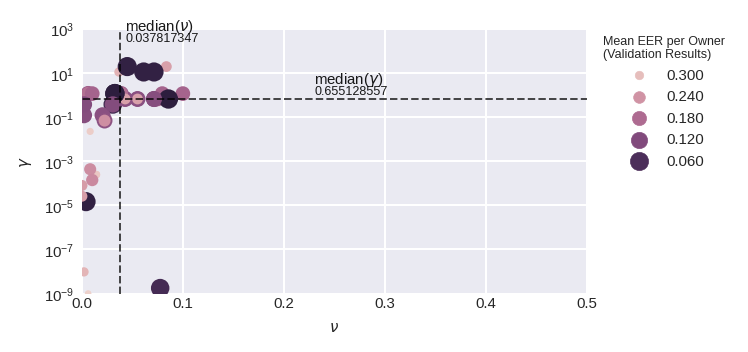

In [151]:
result_dict = utils_plot_randomsearch_results(df_results, n_top=1, plot=True)
P.ocsvm_nu, P.ocsvm_gamma, fig = result_dict["median_nu"], result_dict["median_gamma"], result_dict["fig"]
P.ocsvm_nu, P.ocsvm_gamma

0, −0.20
1, −0.16
2, −0.12
3, −0.08
4, −0.04
5, 0.00
['0.200', '0.160', '0.120', '0.080', '0.040', '0.000']


(0.03577857142857143, 0.039069399370546126)

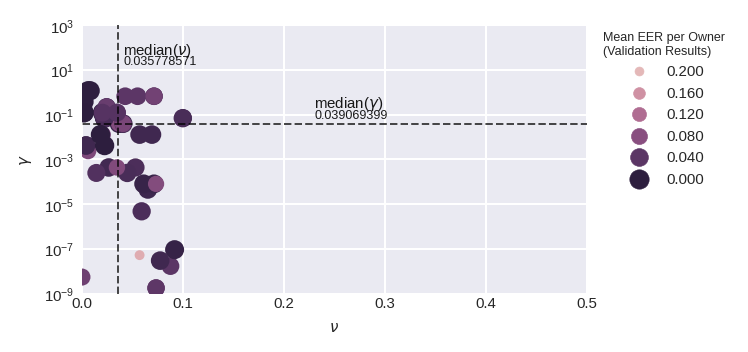

In [98]:
result_dict = utils_plot_randomsearch_results(df_results, n_top=1, plot=True)
P.ocsvm_nu, P.ocsvm_gamma, fig = result_dict["median_nu"], result_dict["median_gamma"], result_dict["fig"]
P.ocsvm_nu, P.ocsvm_gamma

In [73]:

# _, _, fig = utils_plot_randomsearch_results(df_results, n_top=1)
P.ocsvm_nu, P.ocsvm_gamma, fig = utils_plot_randomsearch_results(df_results[(df_results.rank_test_eer == 1) & (df_results.mean_test_eer < 0.5)], n_top=1)
plt.savefig(f'WACA-OCSVM-Nu_Gamma_plot-win_size={P.window_size}-step_width={P.ocsvm_step_width}-smoothing:{P.smoothing}.svg', bbox_inches='tight')

<Figure size 1152x792 with 0 Axes>

In [74]:
fig.savefig(f'WACA-OCSVM-Nu_Gamma_plot-win_size={P.window_size}-step_width={P.ocsvm_step_width}-smoothing:{P.smoothing}.svg', bbox_inches='tight')

AttributeError: 'str' object has no attribute 'savefig'

In [77]:
print(f"P.ocsvm_nu={P.ocsvm_nu}, P.ocsvm_gamma={P.ocsvm_gamma}")

P.ocsvm_nu=0.053108163265306124, P.ocsvm_gamma=0.00042919342601287783


In [ ]:
print(f"P.ocsvm_nu={P.ocsvm_nu}, P.ocsvm_gamma={P.ocsvm_gamma}")

In [161]:
df_results[(df_results.rank_test_eer == 1) & (df_results.mean_test_eer != 0.5)].groupby('owner').head(232)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__nu,param_model__gamma,24_test_eer,8_test_eer,11_test_eer,13_test_eer,19_test_eer,28_test_eer,21_test_eer,26_test_eer,3_test_eer,20_test_eer,22_test_eer,6_test_eer,25_test_eer,16_test_eer,1_test_eer,17_test_eer,27_test_eer,5_test_eer,29_test_eer,mean_test_eer,std_test_eer,rank_test_eer,24_test_accuracy,8_test_accuracy,11_test_accuracy,13_test_accuracy,19_test_accuracy,28_test_accuracy,21_test_accuracy,26_test_accuracy,3_test_accuracy,20_test_accuracy,22_test_accuracy,6_test_accuracy,25_test_accuracy,16_test_accuracy,1_test_accuracy,17_test_accuracy,27_test_accuracy,5_test_accuracy,29_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,owner,run,7_test_eer,7_test_accuracy
49,0.000616,0.000011,0.000844,0.000019,0.000816,0.039069,0.444444,0.444444,0.444444,0.444444,0.444444,0.444444,0.444444,0.444444,0.444444,0.444444,0.444444,0.444444,0.444444,0.444444,0.444444,0.444444,0.444444,0.444444,0.444444,0.444444,0.000000e+00,1,0.600,0.600,0.600,0.600,0.600,0.600,0.600,0.600,0.600,0.600,0.600,0.600,0.600,0.600,0.600,0.600,0.600,0.600,0.600,0.600000,0.000000,1,7,0,NaN,NaN
94,0.000607,0.000020,0.000858,0.000085,0.000724,0.012649,NaN,0.230769,0.250000,0.230769,0.230769,0.230769,0.230769,0.230769,0.230769,0.230769,0.230769,0.230769,0.230769,0.230769,0.230769,0.230769,0.230769,0.230769,0.230769,0.231781,4.294171e-03,1,NaN,0.850,0.800,0.850,0.850,0.850,0.850,0.850,0.850,0.850,0.850,0.850,0.850,0.850,0.850,0.850,0.850,0.850,0.850,0.847368,0.011165,1,24,0,0.230769,0.850
109,0.000607,0.000014,0.000851,0.000093,0.000522,0.012649,NaN,0.230769,0.250000,0.230769,0.230769,0.230769,0.230769,0.230769,0.230769,0.230769,0.230769,0.230769,0.230769,0.230769,0.230769,0.230769,0.230769,0.230769,0.230769,0.231781,4.294171e-03,1,NaN,0.850,0.800,0.850,0.850,0.850,0.850,0.850,0.850,0.850,0.850,0.850,0.850,0.850,0.850,0.850,0.850,0.850,0.850,0.847368,0.011165,1,24,0,0.230769,0.850
229,0.000623,0.000036,0.000907,0.000140,0.000945,0.007197,0.240000,NaN,0.230769,0.230769,0.230769,0.230769,0.230769,0.230769,0.230769,0.230769,0.230769,0.230769,0.230769,0.416667,0.240000,0.230769,0.230769,0.230769,0.240000,0.255206,6.740451e-02,1,0.825,NaN,0.850,0.850,0.850,0.850,0.850,0.850,0.850,0.850,0.850,0.850,0.850,0.600,0.825,0.850,0.850,0.850,0.825,0.815789,0.088187,1,8,0,0.481481,0.525
289,0.000620,0.000014,0.000842,0.000026,0.000816,0.039069,0.487179,0.487179,NaN,0.487179,0.487179,0.487179,0.487179,0.487179,0.487179,0.487179,0.487179,0.487179,0.487179,0.487179,0.487179,0.487179,0.487179,0.487179,0.487179,0.487179,5.551115e-17,1,0.525,0.525,NaN,0.525,0.525,0.525,0.525,0.525,0.525,0.525,0.525,0.525,0.525,0.525,0.525,0.525,0.525,0.525,0.525,0.525000,0.000000,1,11,0,0.487179,0.525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4590,0.000612,0.000013,0.000950,0.000401,0.000945,0.007197,0.428571,0.428571,0.428571,0.428571,0.428571,0.441176,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,0.441176,0.428571,0.428571,0.428571,NaN,0.428571,0.428571,0.429898,3.868389e-03,1,0.625,0.625,0.625,0.625,0.625,0.600,0.625,0.625,0.625,0.625,0.625,0.625,0.600,0.625,0.625,0.625,NaN,0.625,0.625,0.622368,0.007672,1,27,2,0.428571,0.625
4651,0.000626,0.000013,0.000843,0.000023,0.000651,0.068665,0.487179,0.487179,0.487179,0.487179,0.487179,0.487179,0.487179,0.487179,0.487179,0.487179,0.487179,0.487179,0.487179,0.487179,0.487179,0.487179,0.487179,NaN,0.487179,0.487179,5.551115e-17,1,0.525,0.525,0.525,0.525,0.525,0.525,0.525,0.525,0.525,0.525,0.525,0.525,0.525,0.525,0.525,0.525,0.525,NaN,0.525,0.525000,0.000000,1,5,2,0.487179,0.525
4669,0.000623,0.000013,0.000842,0.000026,0.000559,0.068665,0.487179,0.487179,0.487179,0.487179,0.487179,0.487179,0.487179,0.487179,0.487179,0.487179,0.487179,0.487179,0.487179,0.487179,0.487179,0.487179,0.487179,Na

In [25]:
X_test_exp1_dict, X_test_exp2_dict, fitted_scaler_test_exp2_dict=get_raw_windows(dfList_exp1, dfList_exp2, window_size, step_width, test_set, P.scaler, P.num_sample_points_per_exp, 
                                                                                    EMA_per_win_span=EMA_per_win_span, SMA_per_win_winsize=SMA_per_win_winsize, Butter_per_win_argdict=P.Butter_per_win_argdict)


X_exp_test_dic = extract_WACA_features(X_test_exp1_dict, X_test_exp2_dict, fitted_scaler_test_exp2_dict)

len(exp1_df_user_set_dict): 10
len(exp2_df_user_set_dict): 10
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:    0.4s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.5s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.6s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:    0.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.9s finished
MakeWACAXExpDicOwner Time:  0.9197355732321739
[Parallel(n_jobs=-1)]: Using back

In [167]:
import time
    
elapsed_time_dict={}

# elapsed_time_dict=
# {1: 1.1274936199188232,
#  2: 1.0859317779541016,
#  3: 1.1646921634674072,
#  4: 1.2141354084014893,
#  5: 1.2444705963134766,
#  6: 1.2584974765777588,
#  7: 1.295924186706543,
#  8: 1.3720738887786865,
#  9: 1.3679378032684326,
#  10: 1.328564167022705,
#  11: 1.379624605178833,
#  12: 1.3409805297851562,
#  13: 1.379106044769287,
#  14: 1.3944427967071533,
#  15: 1.423699140548706,
#  16: 1.354649543762207,
#  17: 1.3932619094848633,
#  18: 1.3947765827178955,
#  19: 1.371302604675293}
for cores in range(2, 3):
    start_time = time.time()
    
    test_df_results = None  # Will be filled with randomsearch scores
    for run in tqdm(range(5)):

        with parallel_backend('loky', n_jobs=-1):
            df_score = Parallel(n_jobs=-1, verbose=0)(delayed(evaluate_owner_classifier_train_test)(owner_key, X_exp_test_dic, SEED, run, cores=cores, exp_config=P, verbose=0) 
                                                               for owner_key in tqdm(X_exp_test_dic.keys(),
                                                                                     desc=f"run: {run}",
                                                                                    ))
        test_df_results = pd.concat([test_df_results] + df_score, sort=False, ignore_index=True, axis=0)
    
    elapsed_time = time.time() - start_time
    elapsed_time_dict[cores]=elapsed_time
    print(f"Elapsed time: {elapsed_time} seconds")
    

100%|██████████| 5/5 [00:01<00:00,  3.96it/s]

Elapsed time: 1.2655317783355713 seconds


In [168]:
elapsed_time_dict

{2: 1.2655317783355713}

In [169]:
evaluate_owner_classifier_train_test(12, X_exp_test_dic, SEED, run, cores=CORES, exp_config=P, verbose=1) 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.1s finished


,fit_time,score_time,test_eer,test_accuracy,test_precision,test_recall,test_f1_score,owner,run,impostors
0,0.001606,0.008319,0.150,0.850,0.850000,0.85,0.85000,12,4,0
1,0.002416,0.006670,0.450,0.550,0.550000,0.55,0.55000,12,4,14
2,0.002486,0.011691,0.000,1.000,1.000000,1.00,1.00000,12,4,9
3,0.002028,0.009045,0.050,0.950,0.950000,0.95,0.95000,12,4,18
4,0.002409,0.008129,0.850,0.150,0.150000,0.15,0.15000,12,4,23
5,0.002424,0.010676,0.025,0.975,0.952381,1.00,0.97561,12,4,2
6,0.002443,0.007945,0.500,0.500,0.500000,0.50,0.50000,12,4,15
7,0.000956,0.004299,0.000,1.000,1.000000,1.00,1.00000,12,4,10
8,0.002492,0.009507,0.500,0.500,0.500000,0.50,0.50000,12,4,4


In [170]:
# df_score

In [171]:
ow, im = 23, 15
print(test_df_results[(test_df_results.owner==ow) & (test_df_results.impostors==im)][["test_eer"]].mean())
test_df_results[(test_df_results.owner==ow) & (test_df_results.impostors==im)][["test_eer"]]

test_eer    0.17
dtype: float64


,test_eer
51,0.175
141,0.150
231,0.175
321,0.175
411,0.175


In [172]:
print(test_df_results.shape)
groupted_df = test_df_results.groupby(['owner', 'impostors', 'run'])["test_eer"].mean()
groupted_df.shape
# for group_name, group_df in groupted_df:
#     print(f"Group: {group_name}")
#     # print(group_df)
#     print()

(450, 10)


(450,)

In [173]:
mean_test_EER=test_df_results.groupby(['owner', 'impostors'])['test_eer'].mean().reset_index()

In [174]:
test_df_results[63:72]

,fit_time,score_time,test_eer,test_accuracy,test_precision,test_recall,test_f1_score,owner,run,impostors
63,0.004414,0.013211,0.150,0.850,0.850000,0.85,0.850000,15,0,0
64,0.004592,0.015044,0.275,0.725,0.736842,0.70,0.717949,15,0,12
65,0.003835,0.010628,0.200,0.800,0.800000,0.80,0.800000,15,0,14
66,0.001225,0.014142,0.050,0.950,1.000000,0.90,0.947368,15,0,9
67,0.002405,0.012431,0.050,0.950,1.000000,0.90,0.947368,15,0,18
68,0.001774,0.011520,0.100,0.900,0.900000,0.90,0.900000,15,0,23
69,0.001907,0.010963,0.200,0.800,0.800000,0.80,0.800000,15,0,2
70,0.001023,0.011345,0.150,0.850,0.850000,0.85,0.850000,15,0,10
71,0.001901,0.004226,0.300,0.700,0.700000,0.70,0.700000,15,0,4


In [175]:
test_df_results[test_df_results.test_precision==0]

,fit_time,score_time,test_eer,test_accuracy,test_precision,test_recall,test_f1_score,owner,run,impostors


In [176]:
test_df_results.test_precision[test_df_results.test_precision==0]

Series([], Name: test_precision, dtype: float64)

In [177]:
# mean_test_EER=test_df_results.groupby(['owner', 'impostors'], sort=False)[['fit_time', 'score_time', 'test_eer', 'train_eer', 'test_accuracy', 
#                                                                            'train_accuracy', 'test_precision', 'train_precision', 'test_recall',
#                                                                            'train_recall']].mean().reset_index()

mean_test_EER=test_df_results.groupby(['owner', 'impostors'], sort=False)[['fit_time', 'score_time', 'test_eer', 'test_accuracy', 
                                                                           'test_precision', 'test_recall', "test_f1_score"]].mean().reset_index()

In [178]:
mean_test_EER.test_eer.mean()

0.13355555555555562

In [179]:
test_df_plot = mean_test_EER.rename(
    columns={"test_f1_score": "Test F1_score","test_recall": "Test Recall" , "test_precision": "Test Precision", "test_accuracy": "Test Accuracy", "test_eer": "Test EER", "owner": "owner"}
).astype({"owner": str})
test_df_plot

,owner,impostors,fit_time,score_time,Test EER,Test Accuracy,Test Precision,Test Recall,Test F1_score
0,0,12,0.004172,0.013479,0.000,1.000,1.000000,1.00,1.000000
1,0,14,0.004341,0.016860,0.000,1.000,1.000000,1.00,1.000000
2,0,9,0.001899,0.014770,0.000,1.000,1.000000,1.00,1.000000
3,0,18,0.002093,0.012236,0.000,1.000,1.000000,1.00,1.000000
4,0,23,0.001949,0.013242,0.000,1.000,1.000000,1.00,1.000000
...,...,...,...,...,...,...,...,...,...
85,4,18,0.001767,0.013457,0.150,0.850,0.888889,0.80,0.842105
86,4,23,0.001165,0.014293,0.075,0.925,0.947368,0.90,0.923077
87,4,2,0.001639,0.010105,0.200,0.800,0.800000,0.80,0.800000
88,4,15,0.001711,0.010123,0.455,0.545,0.545263,0.54,0.542564


Overall mean: 0.1336
Overall mean: 0.8664
Overall mean: 0.8790
Overall mean: 0.8551
Overall mean: 0.8651


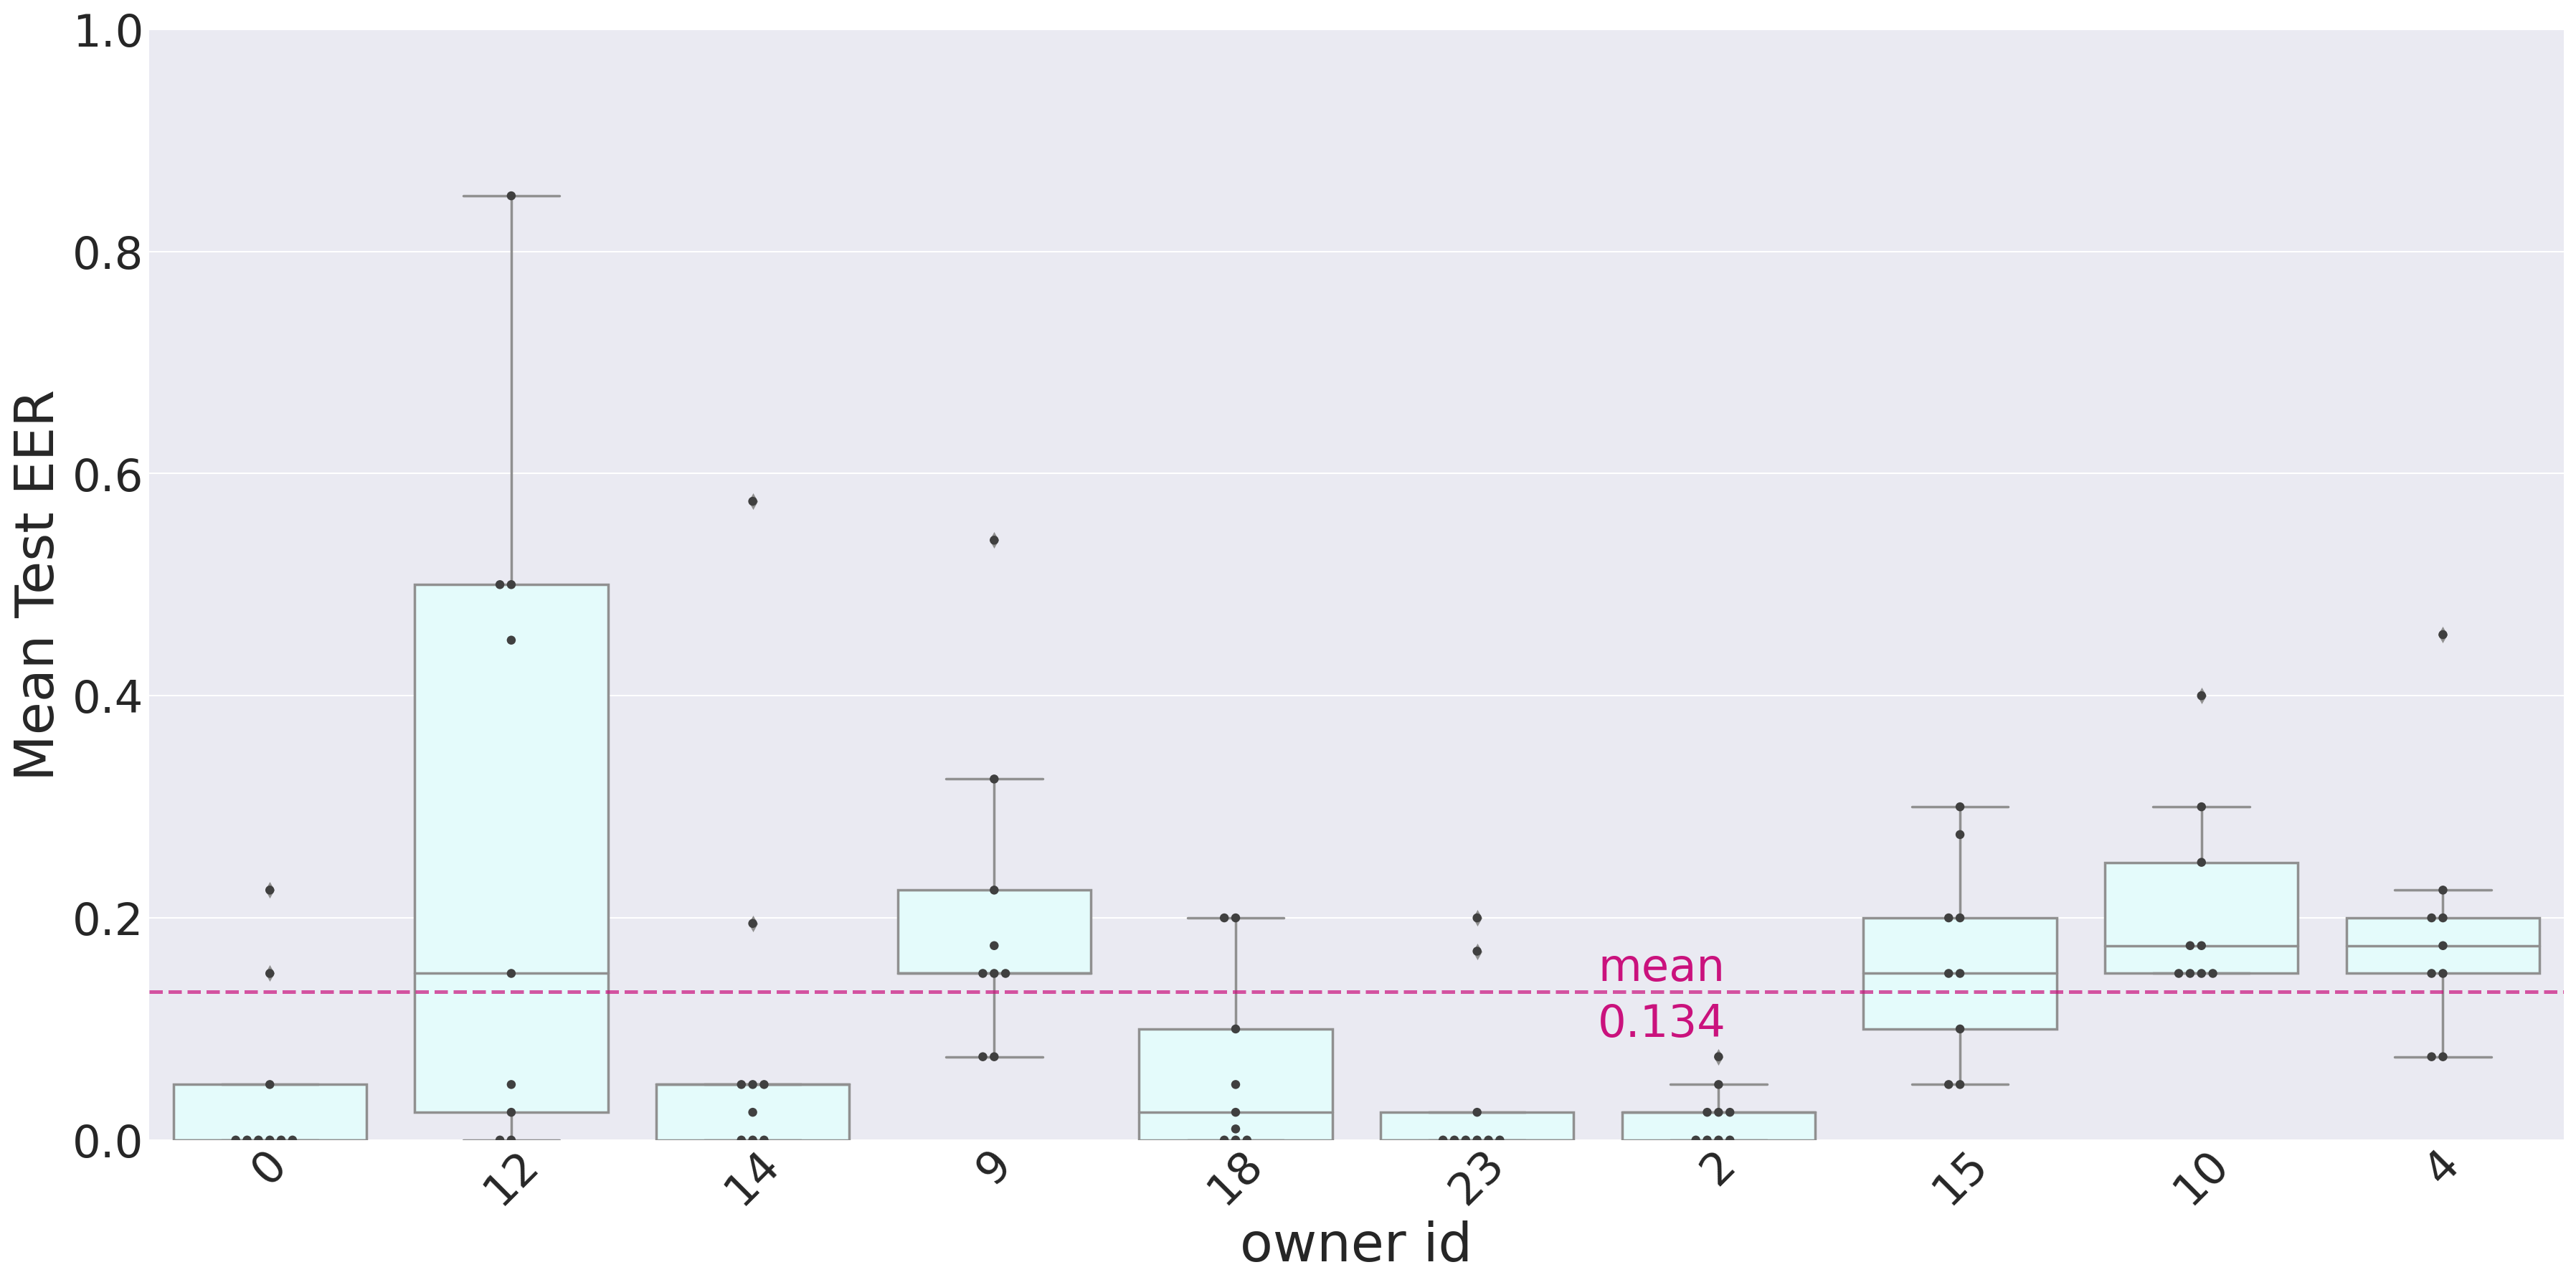

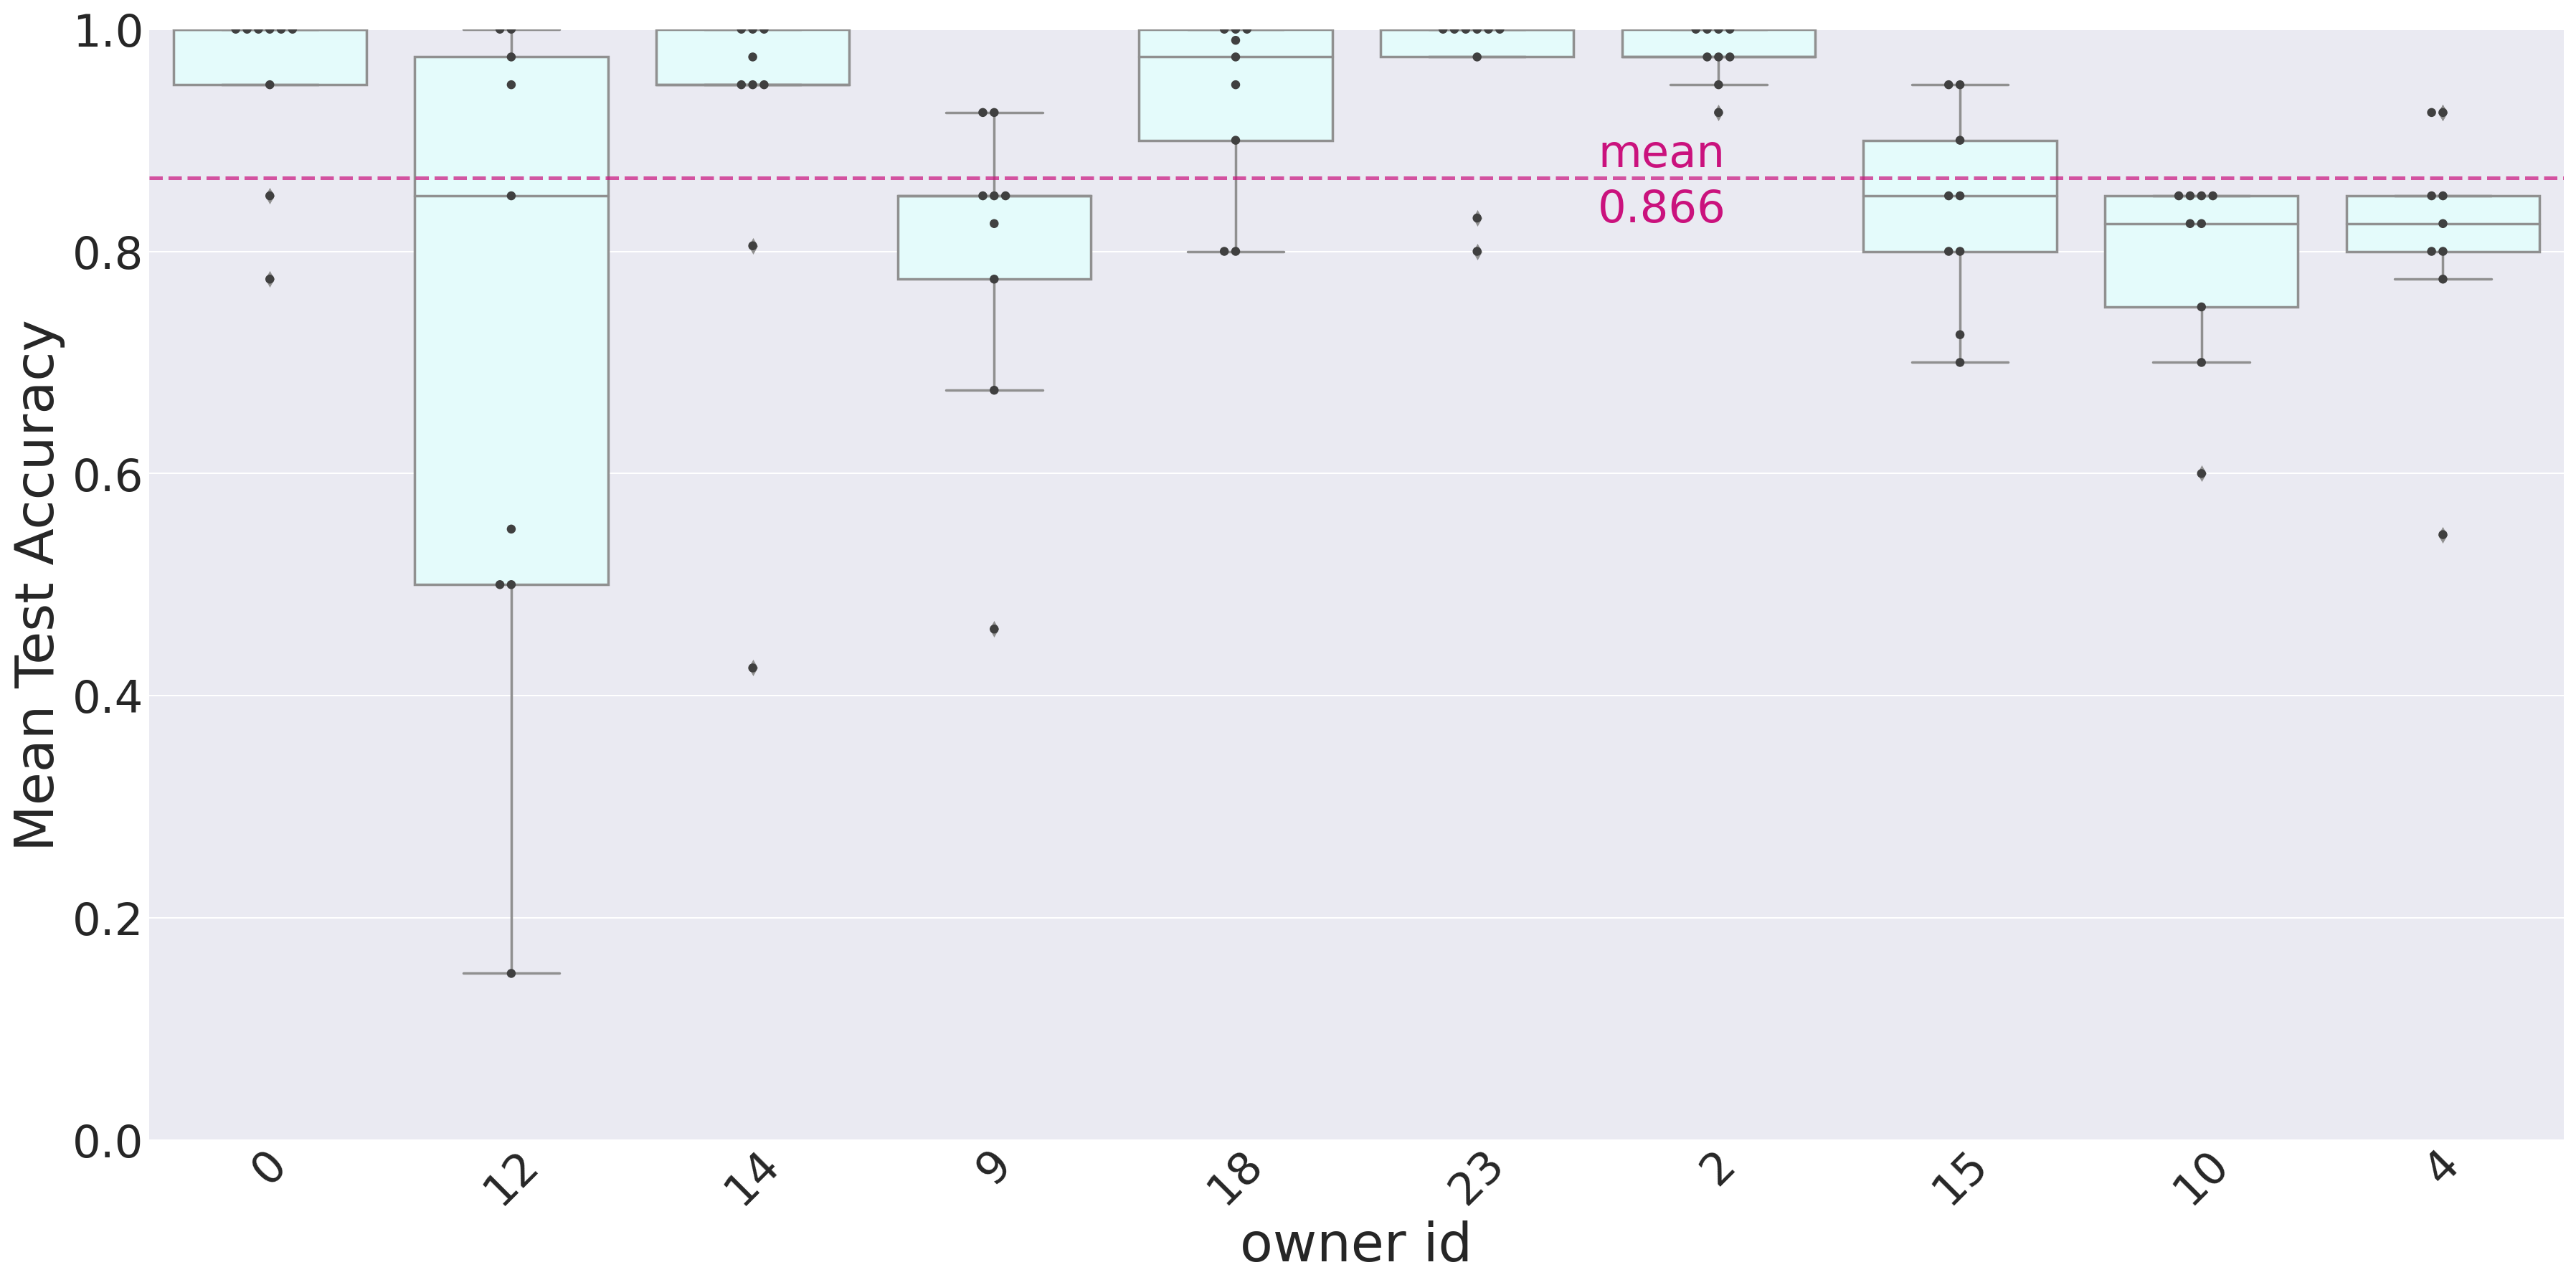

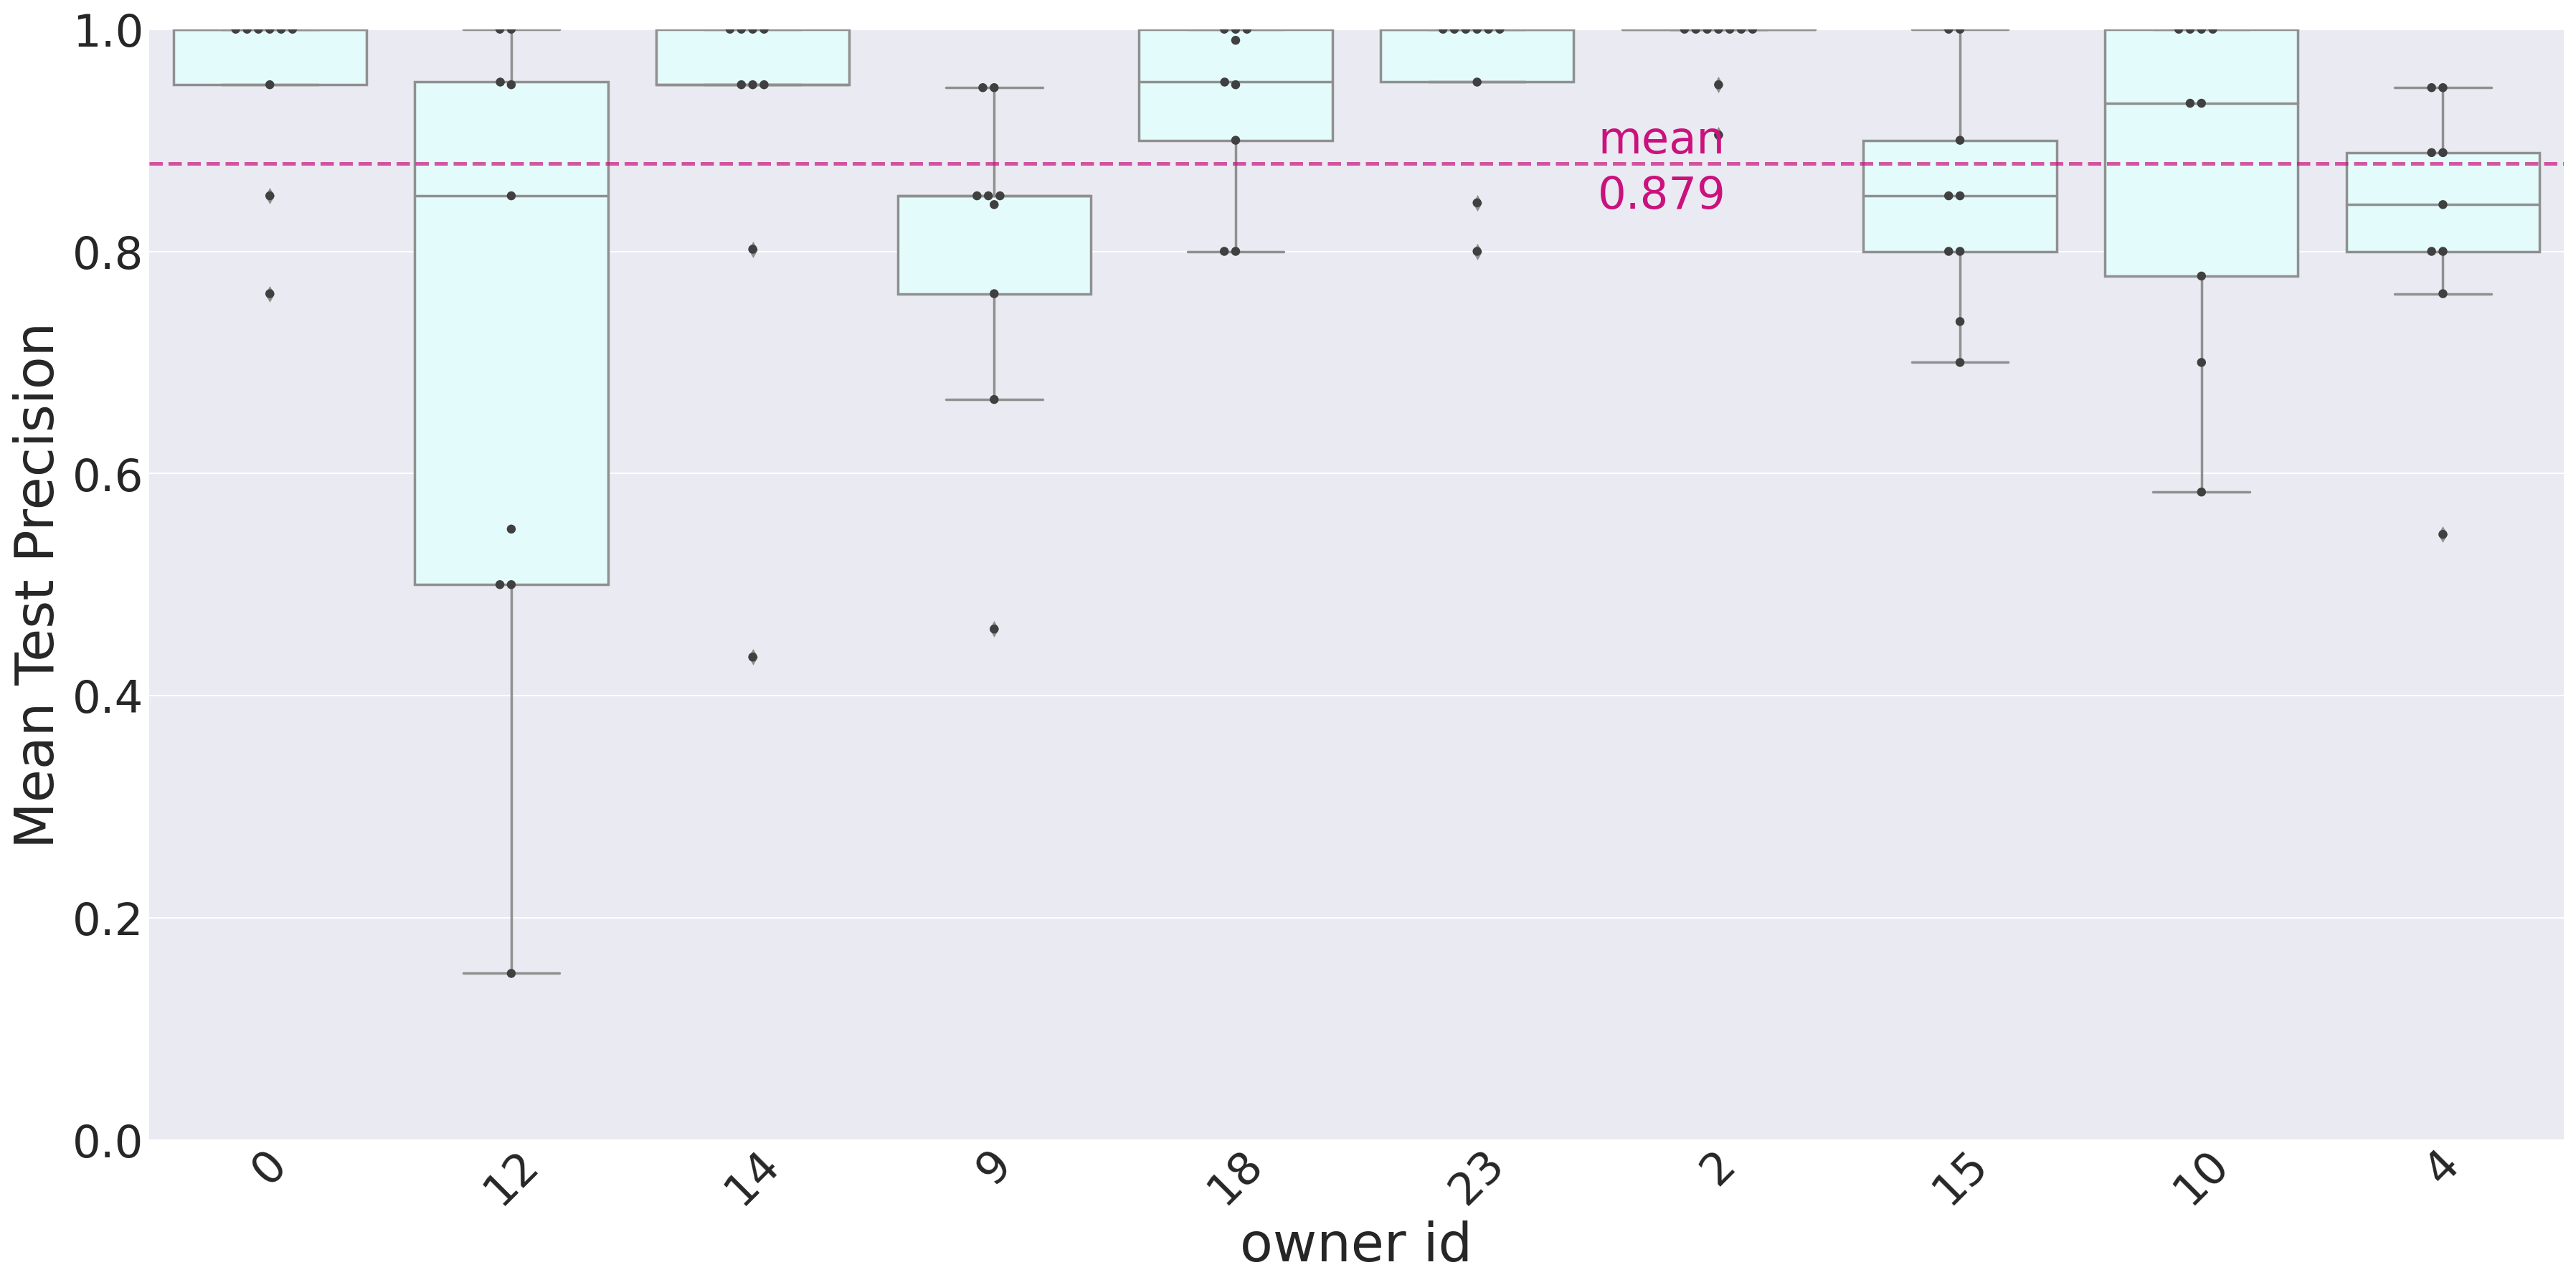

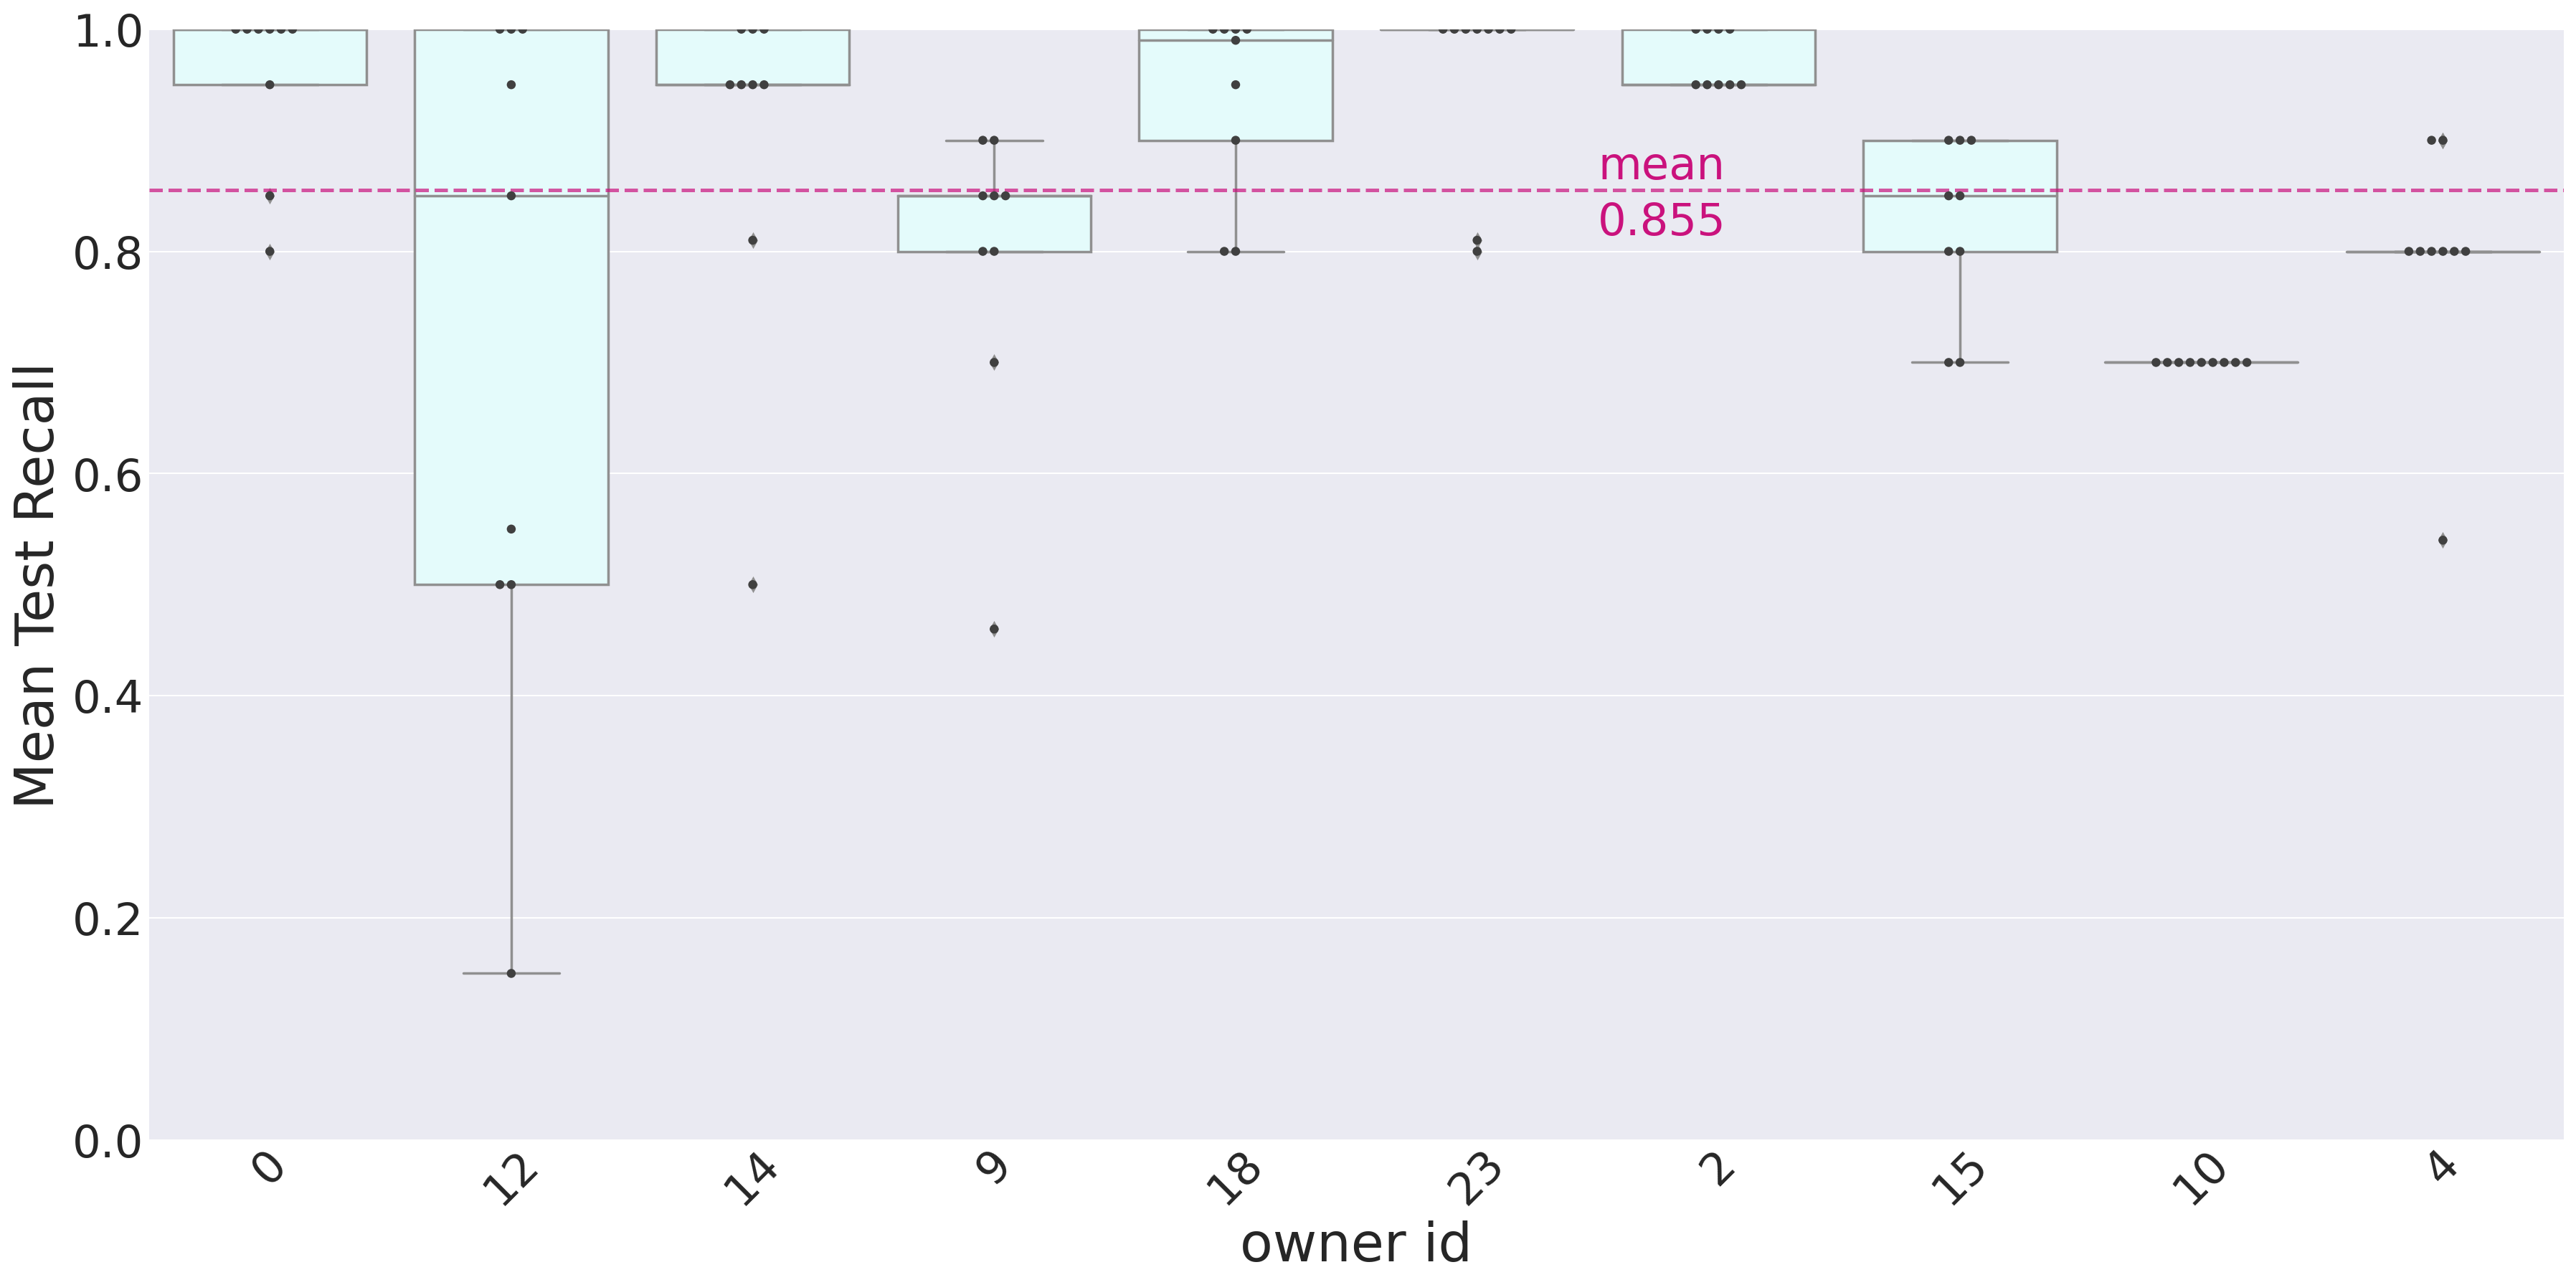

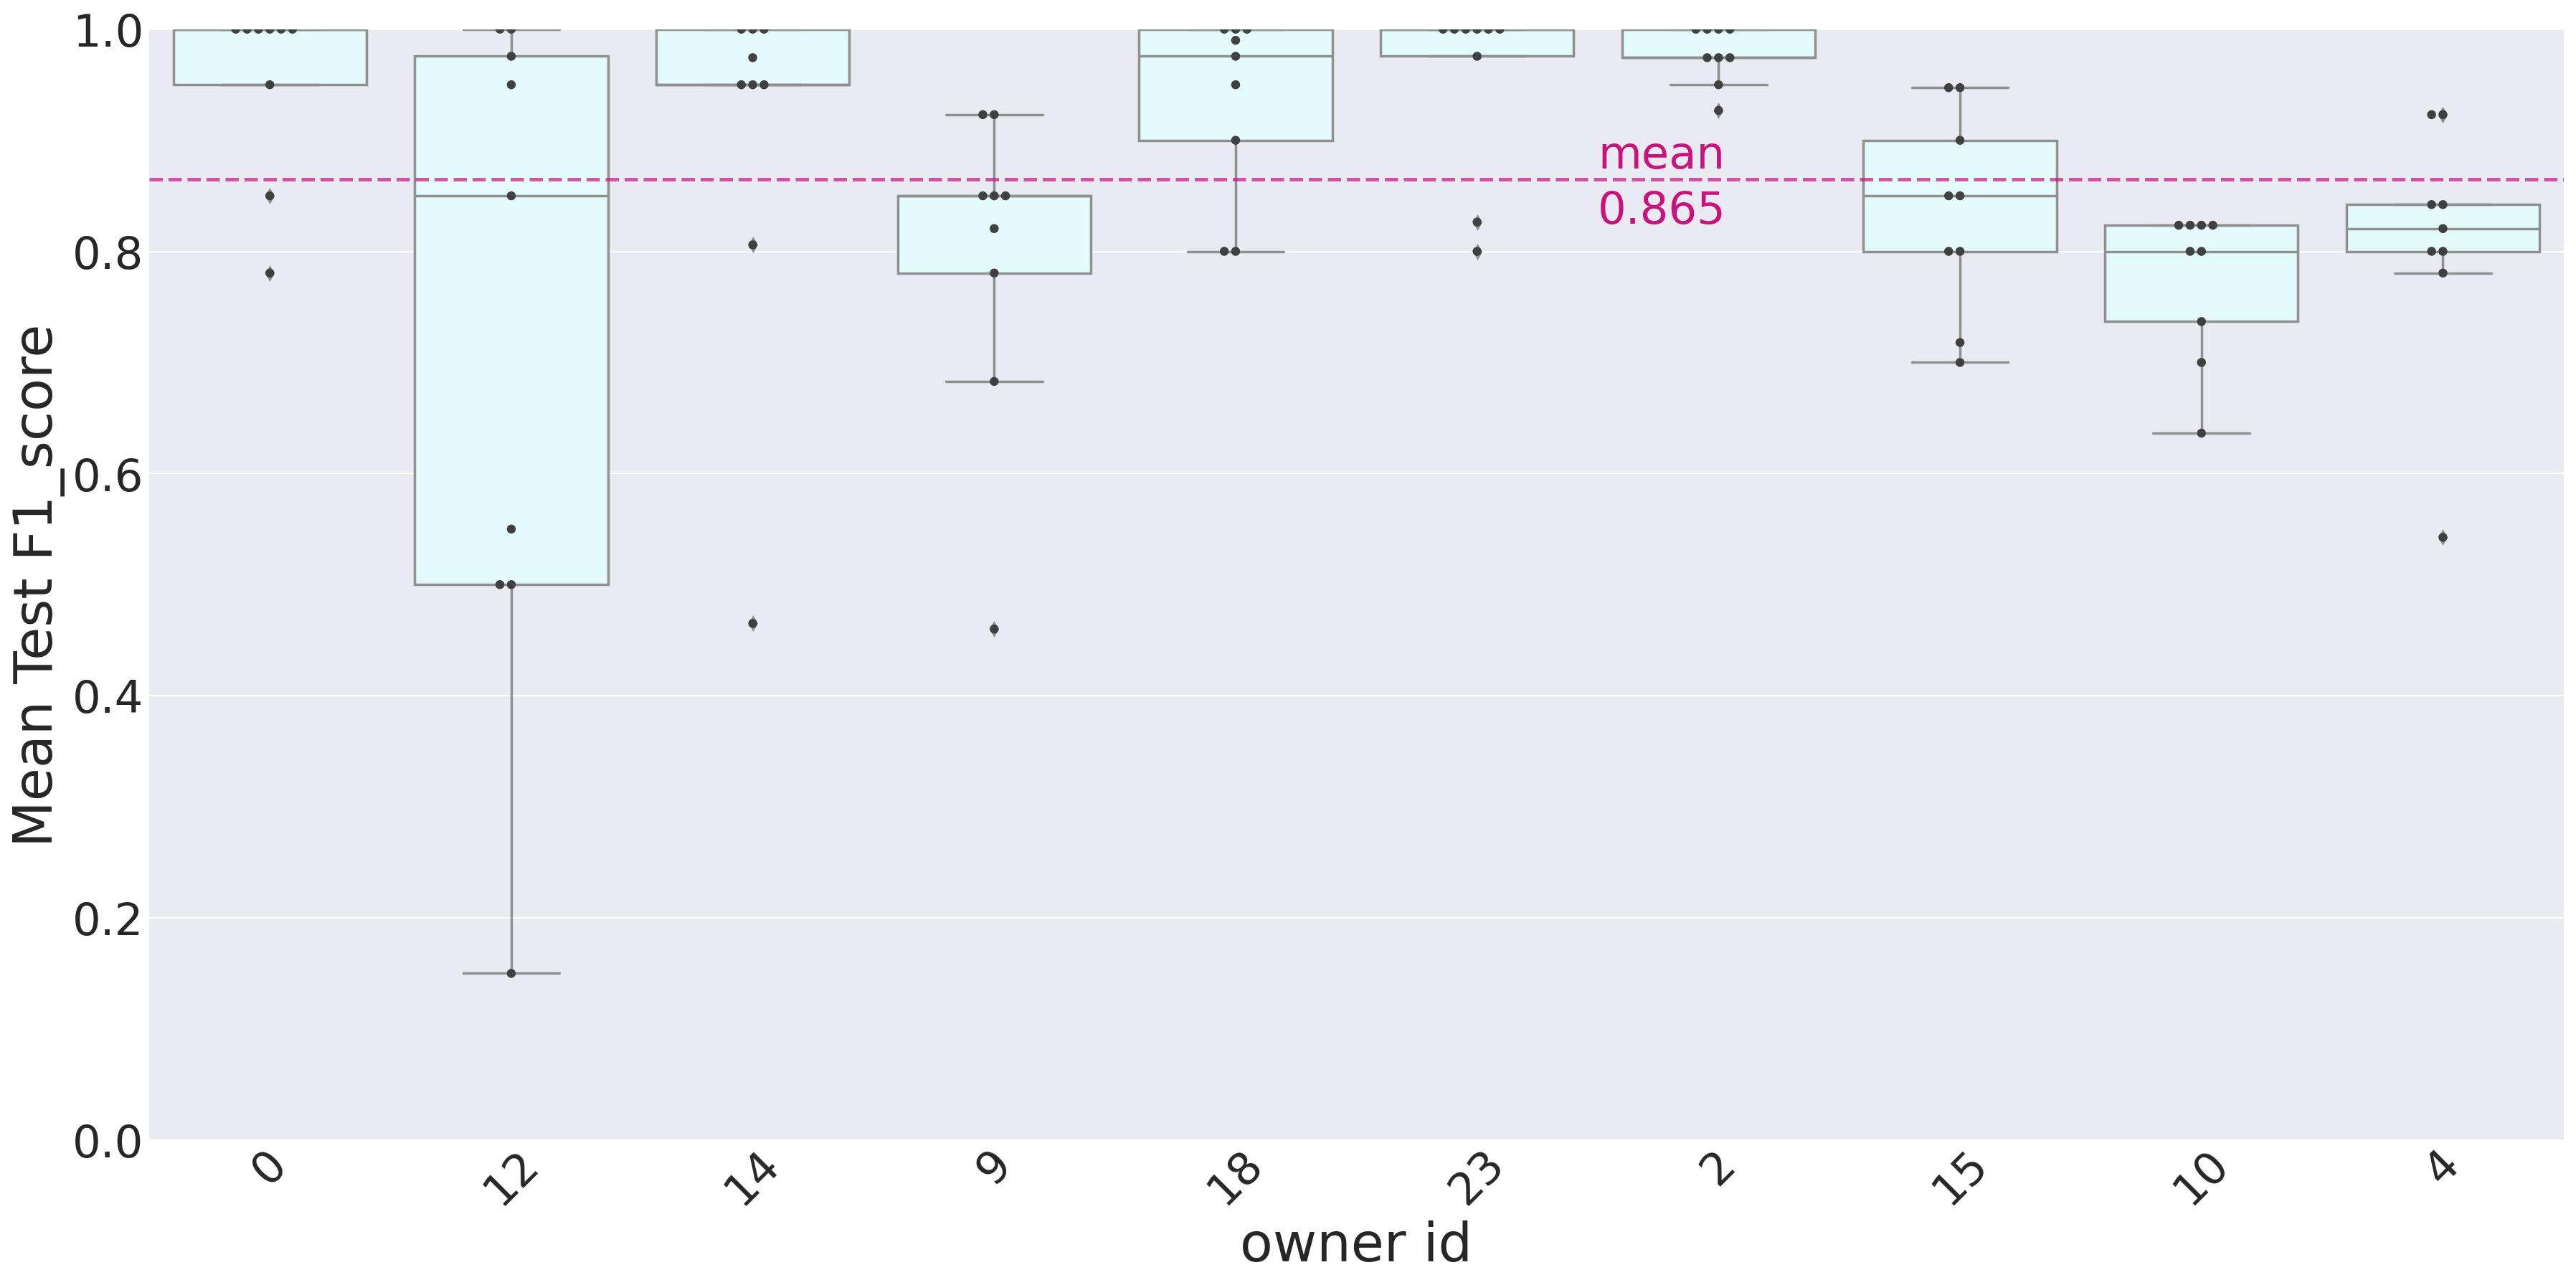

SEED: 567
--------------------SEED and CONSTANTS imported--------------------


In [180]:
utils_plot_acc_eer_dist_thesis(test_df_plot, 'Test EER', '', boxplot_color="lightcyan", save_file_name="WACA-OCSVM-750-Test_EER.svg")
utils_plot_acc_eer_dist_thesis(test_df_plot, 'Test Accuracy', '', boxplot_color="lightcyan", save_file_name="WACA-OCSVM-750-Test_Acc.svg")
utils_plot_acc_eer_dist_thesis(test_df_plot, 'Test Precision', '', boxplot_color="lightcyan", save_file_name="WACA-OCSVM-750-Test_Acc.svg")
utils_plot_acc_eer_dist_thesis(test_df_plot, 'Test Recall', '', boxplot_color="lightcyan", save_file_name="WACA-OCSVM-750-Test_Acc.svg")
utils_plot_acc_eer_dist_thesis(test_df_plot, 'Test F1_score', '', boxplot_color="lightcyan", save_file_name="WACA-OCSVM-750-Test_Acc.svg")

%run ./SEED-CONSTANTS.ipynb

Overall mean: 0.2924
Overall mean: 0.7076


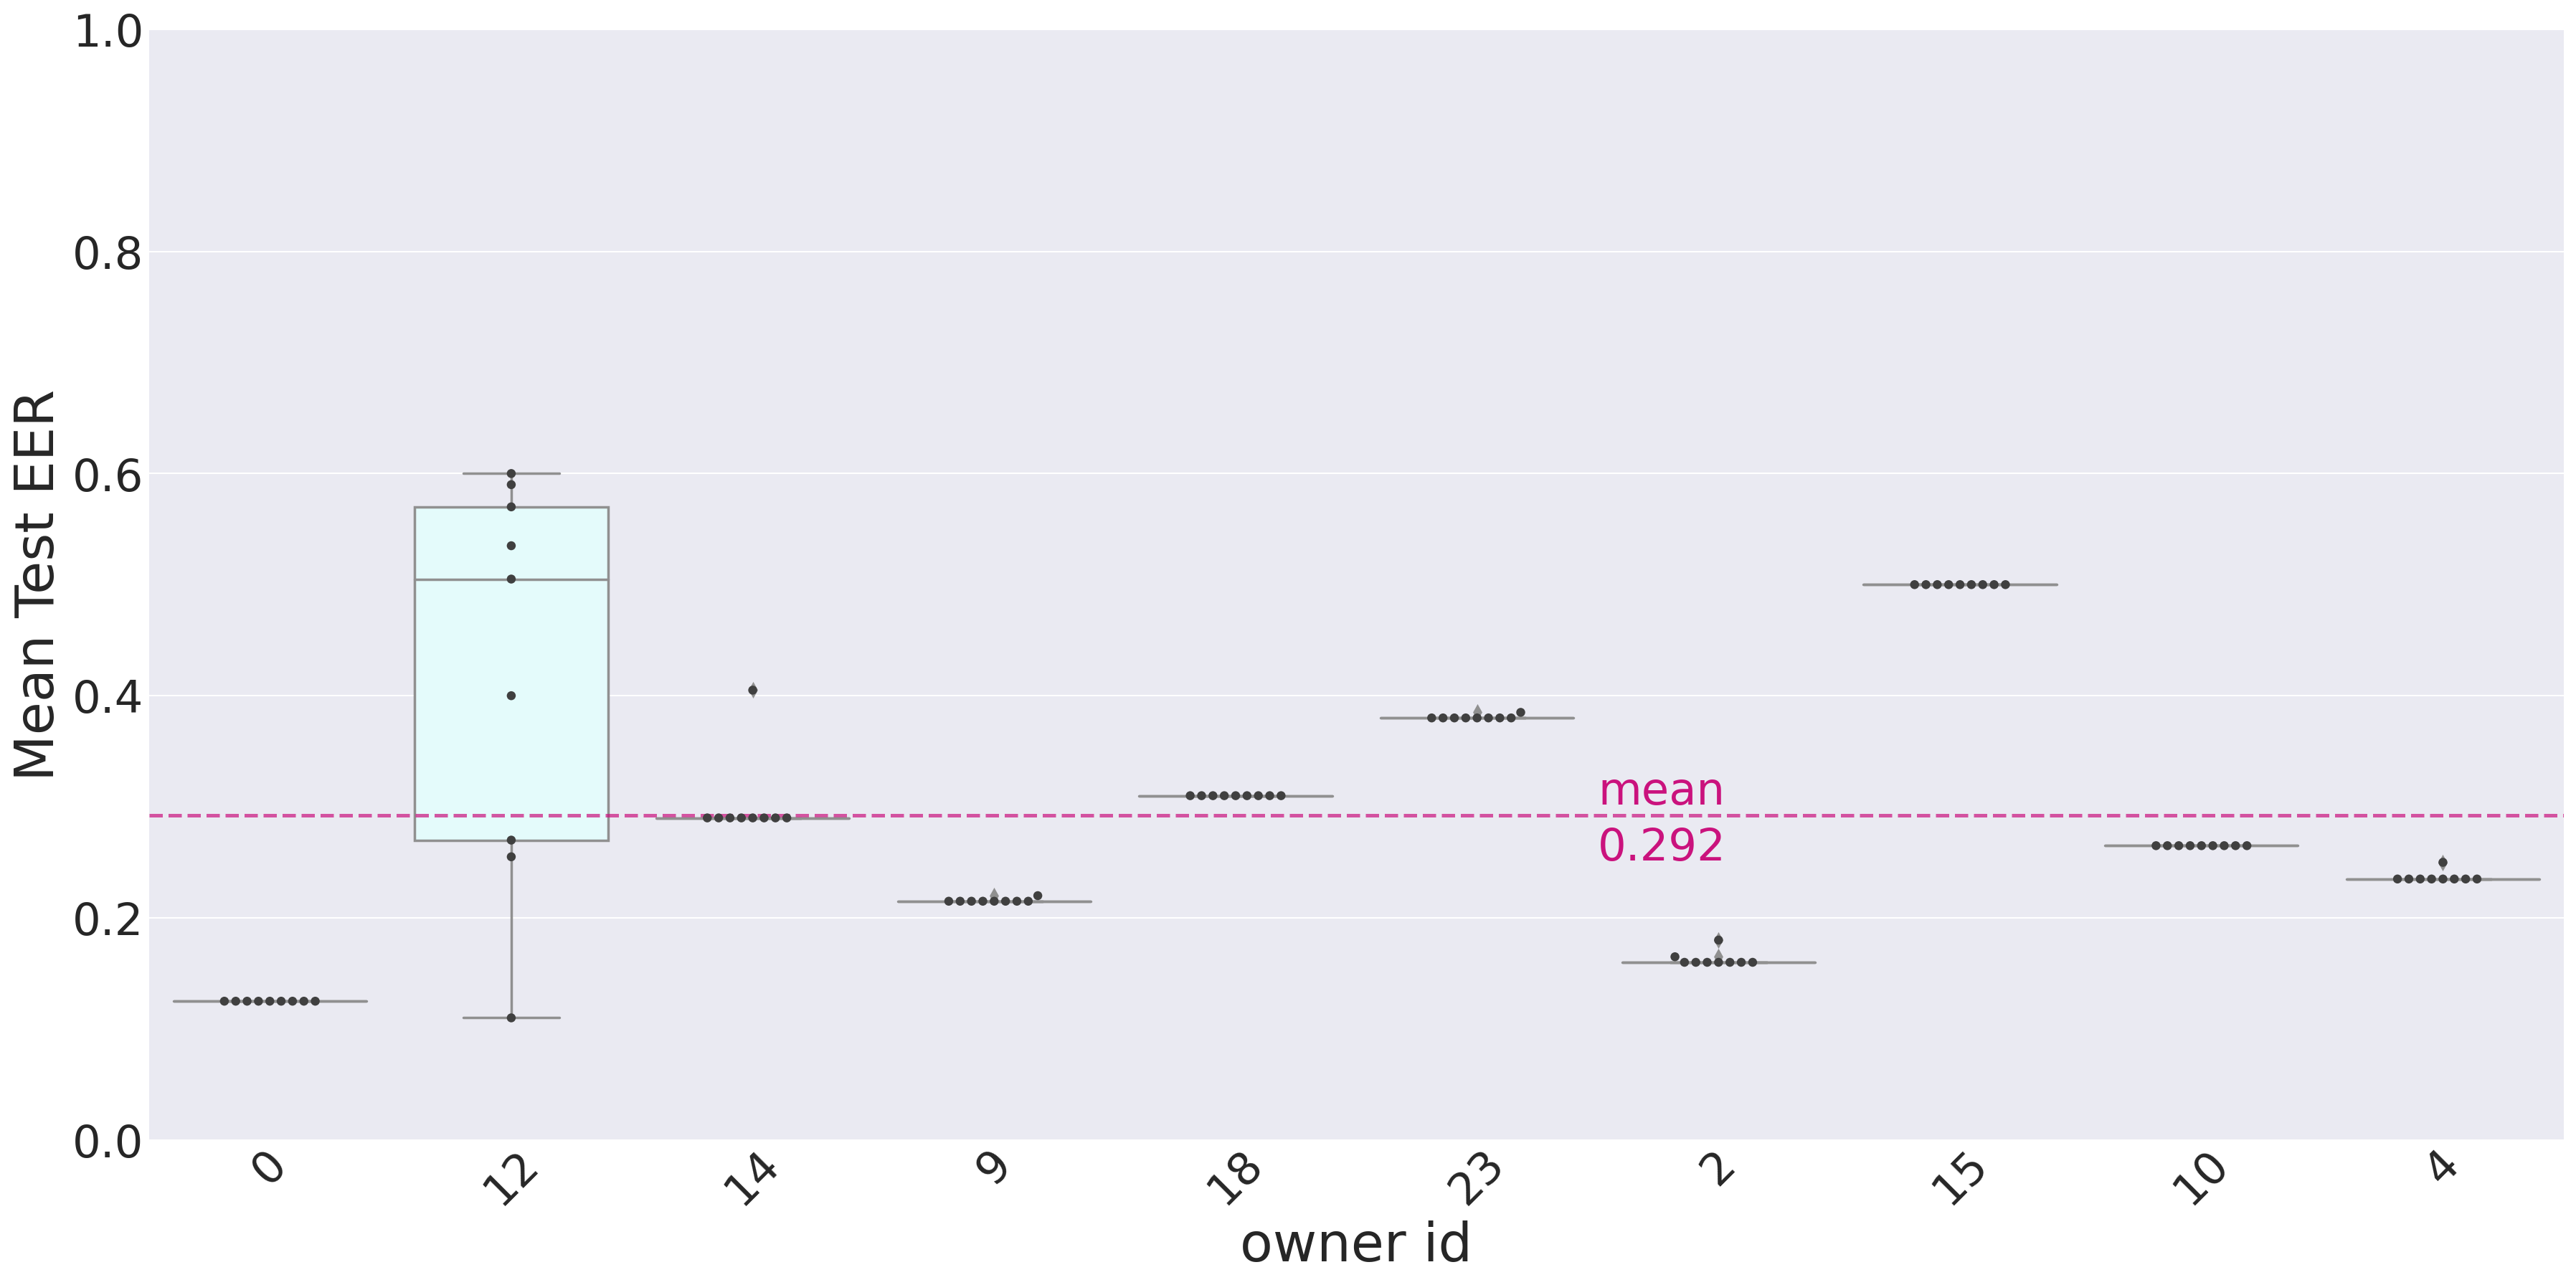

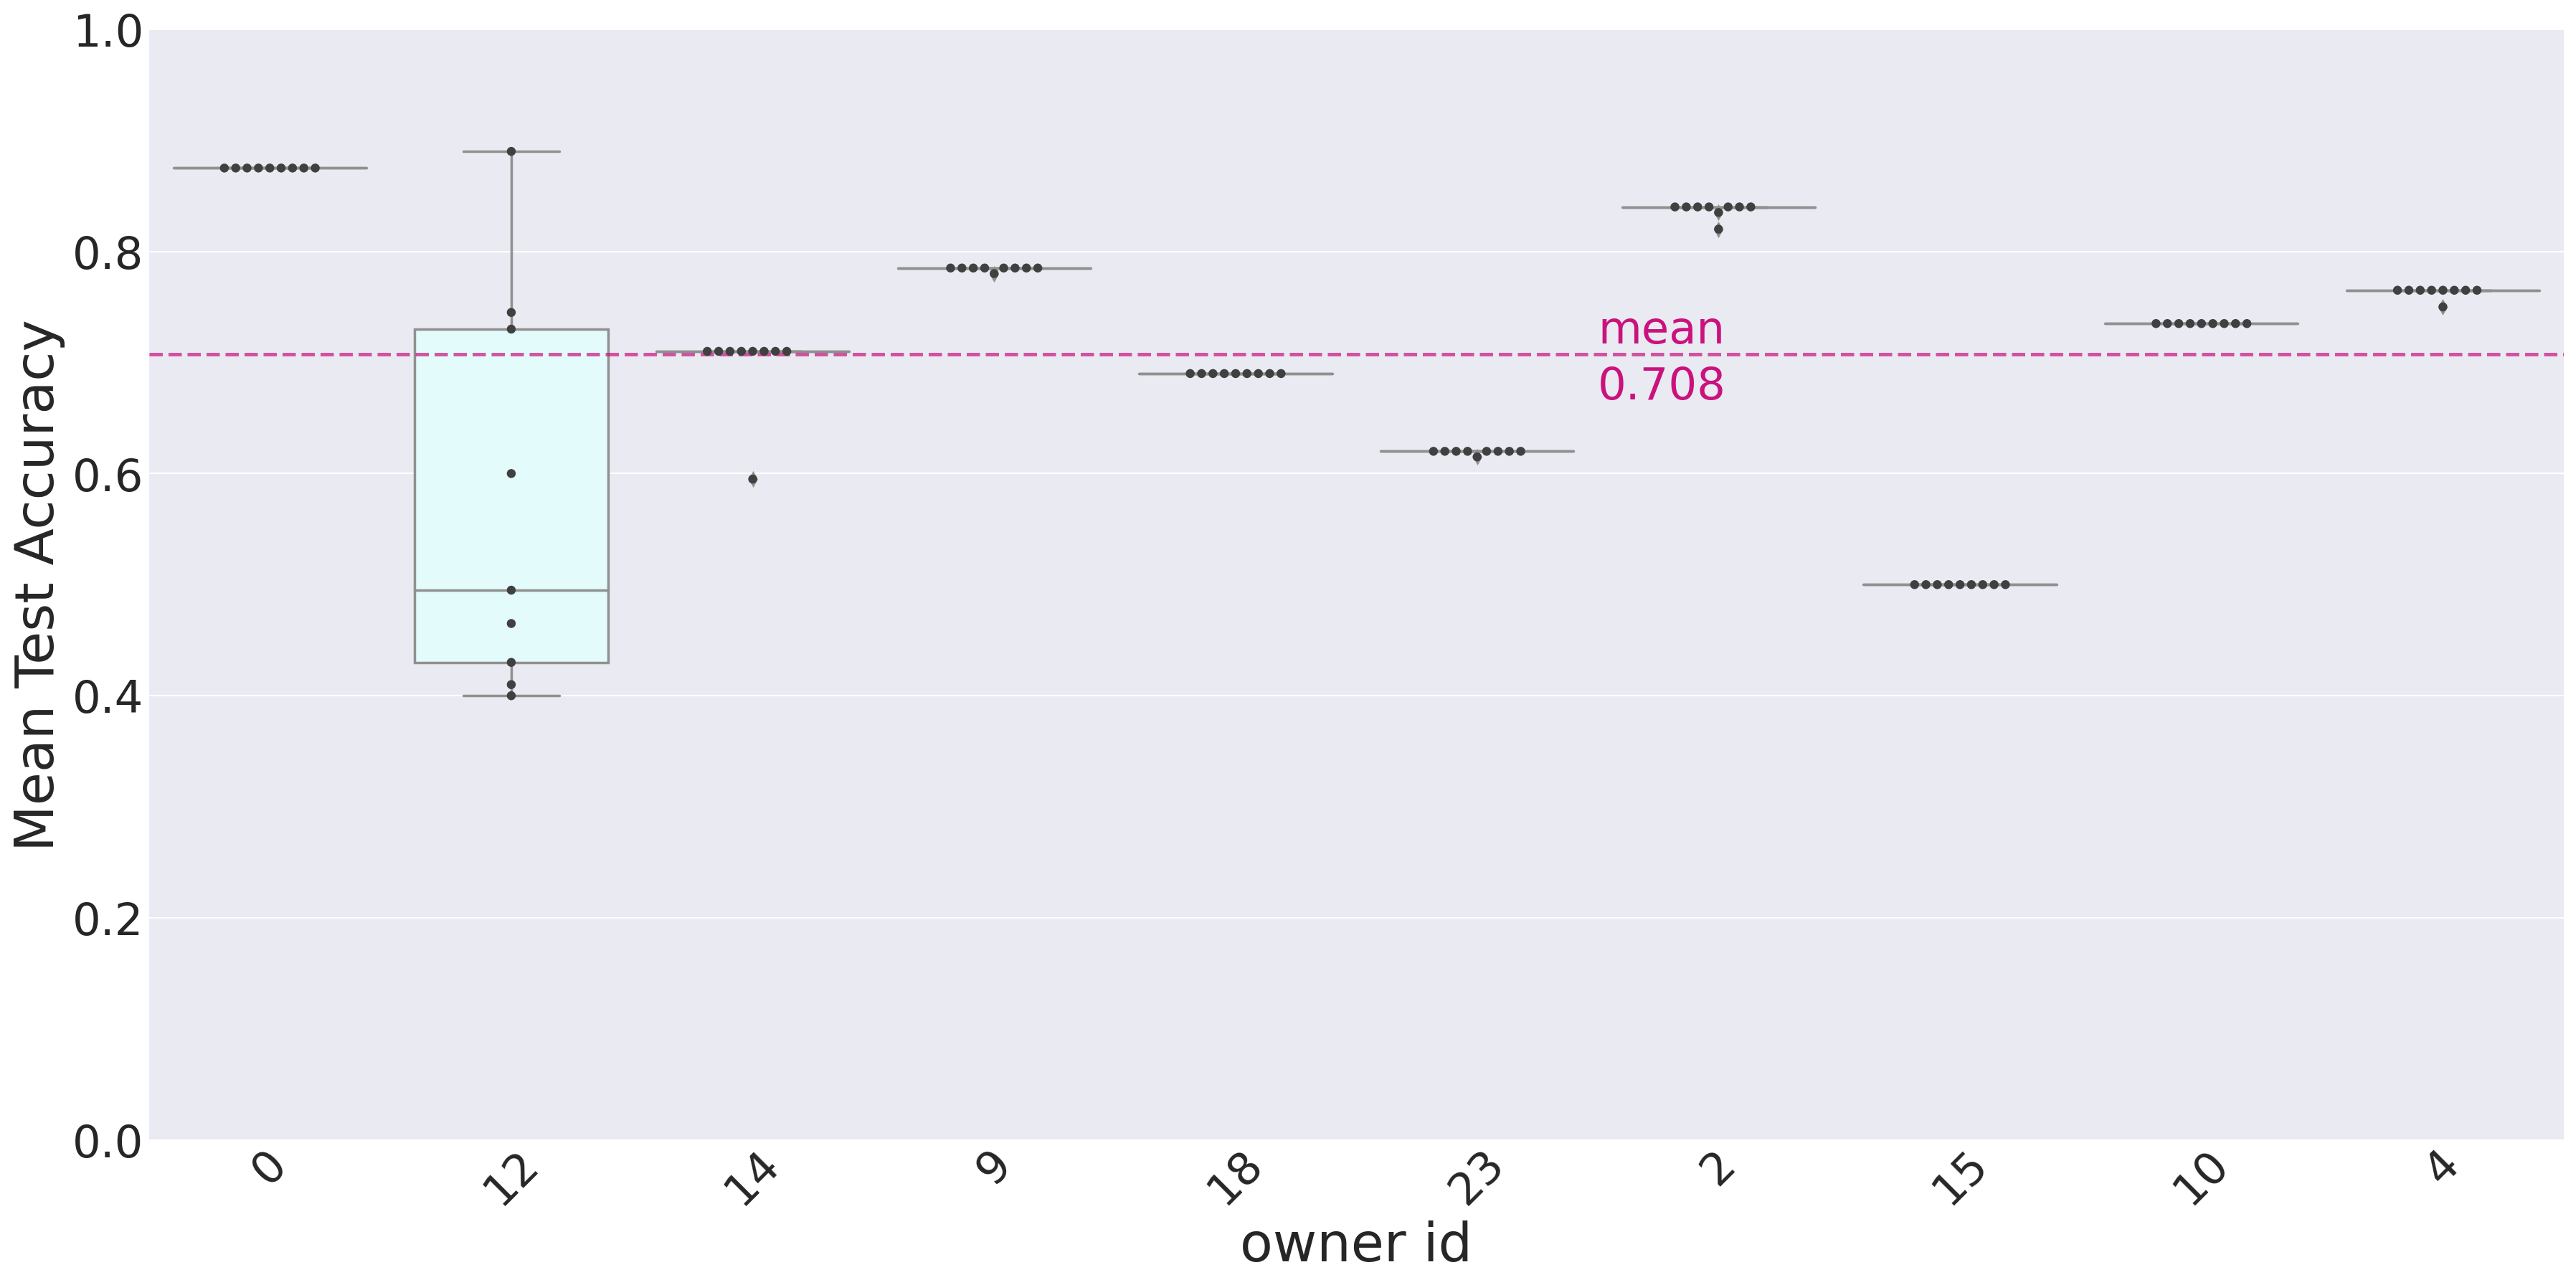

SEED: 567
--------------------SEED and CONSTANTS imported--------------------


In [104]:
utils_plot_acc_eer_dist_thesis(test_df_plot, 'Test EER', '', boxplot_color="lightcyan", save_file_name="WACA-OCSVM-750-Test_EER.svg")
utils_plot_acc_eer_dist_thesis(test_df_plot, 'Test Accuracy', '', boxplot_color="lightcyan", save_file_name="WACA-OCSVM-750-Test_Acc.svg")
%run ./SEED-CONSTANTS.ipynb


Overall mean: 0.3516
Overall mean: 0.7076


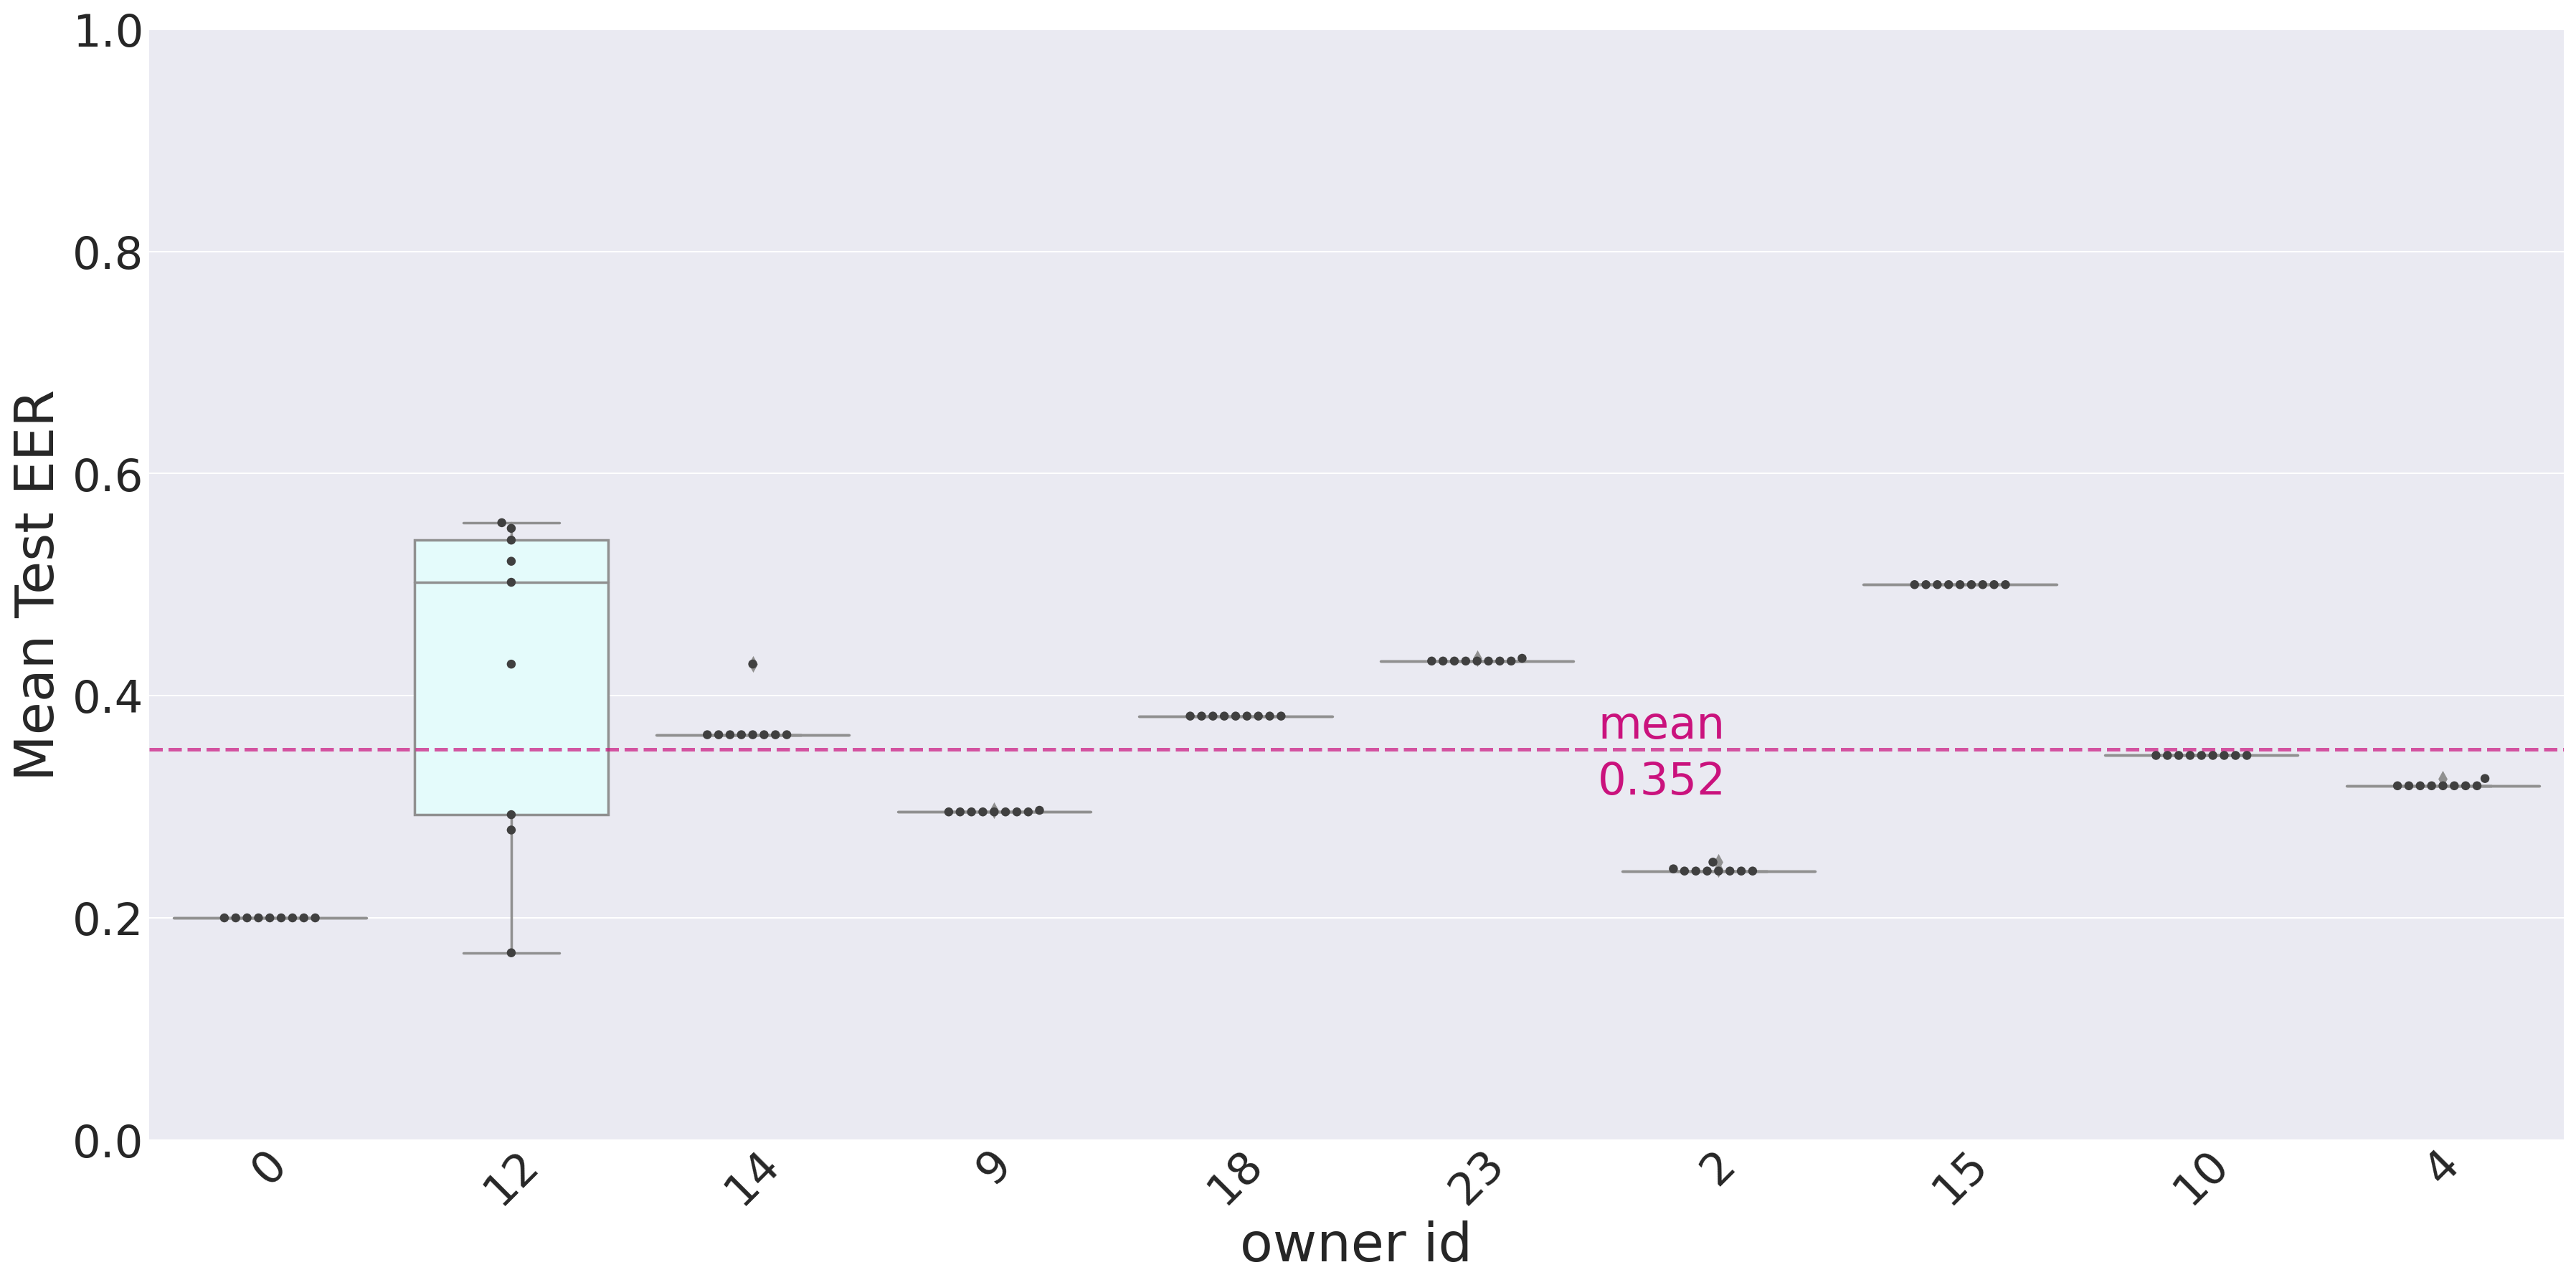

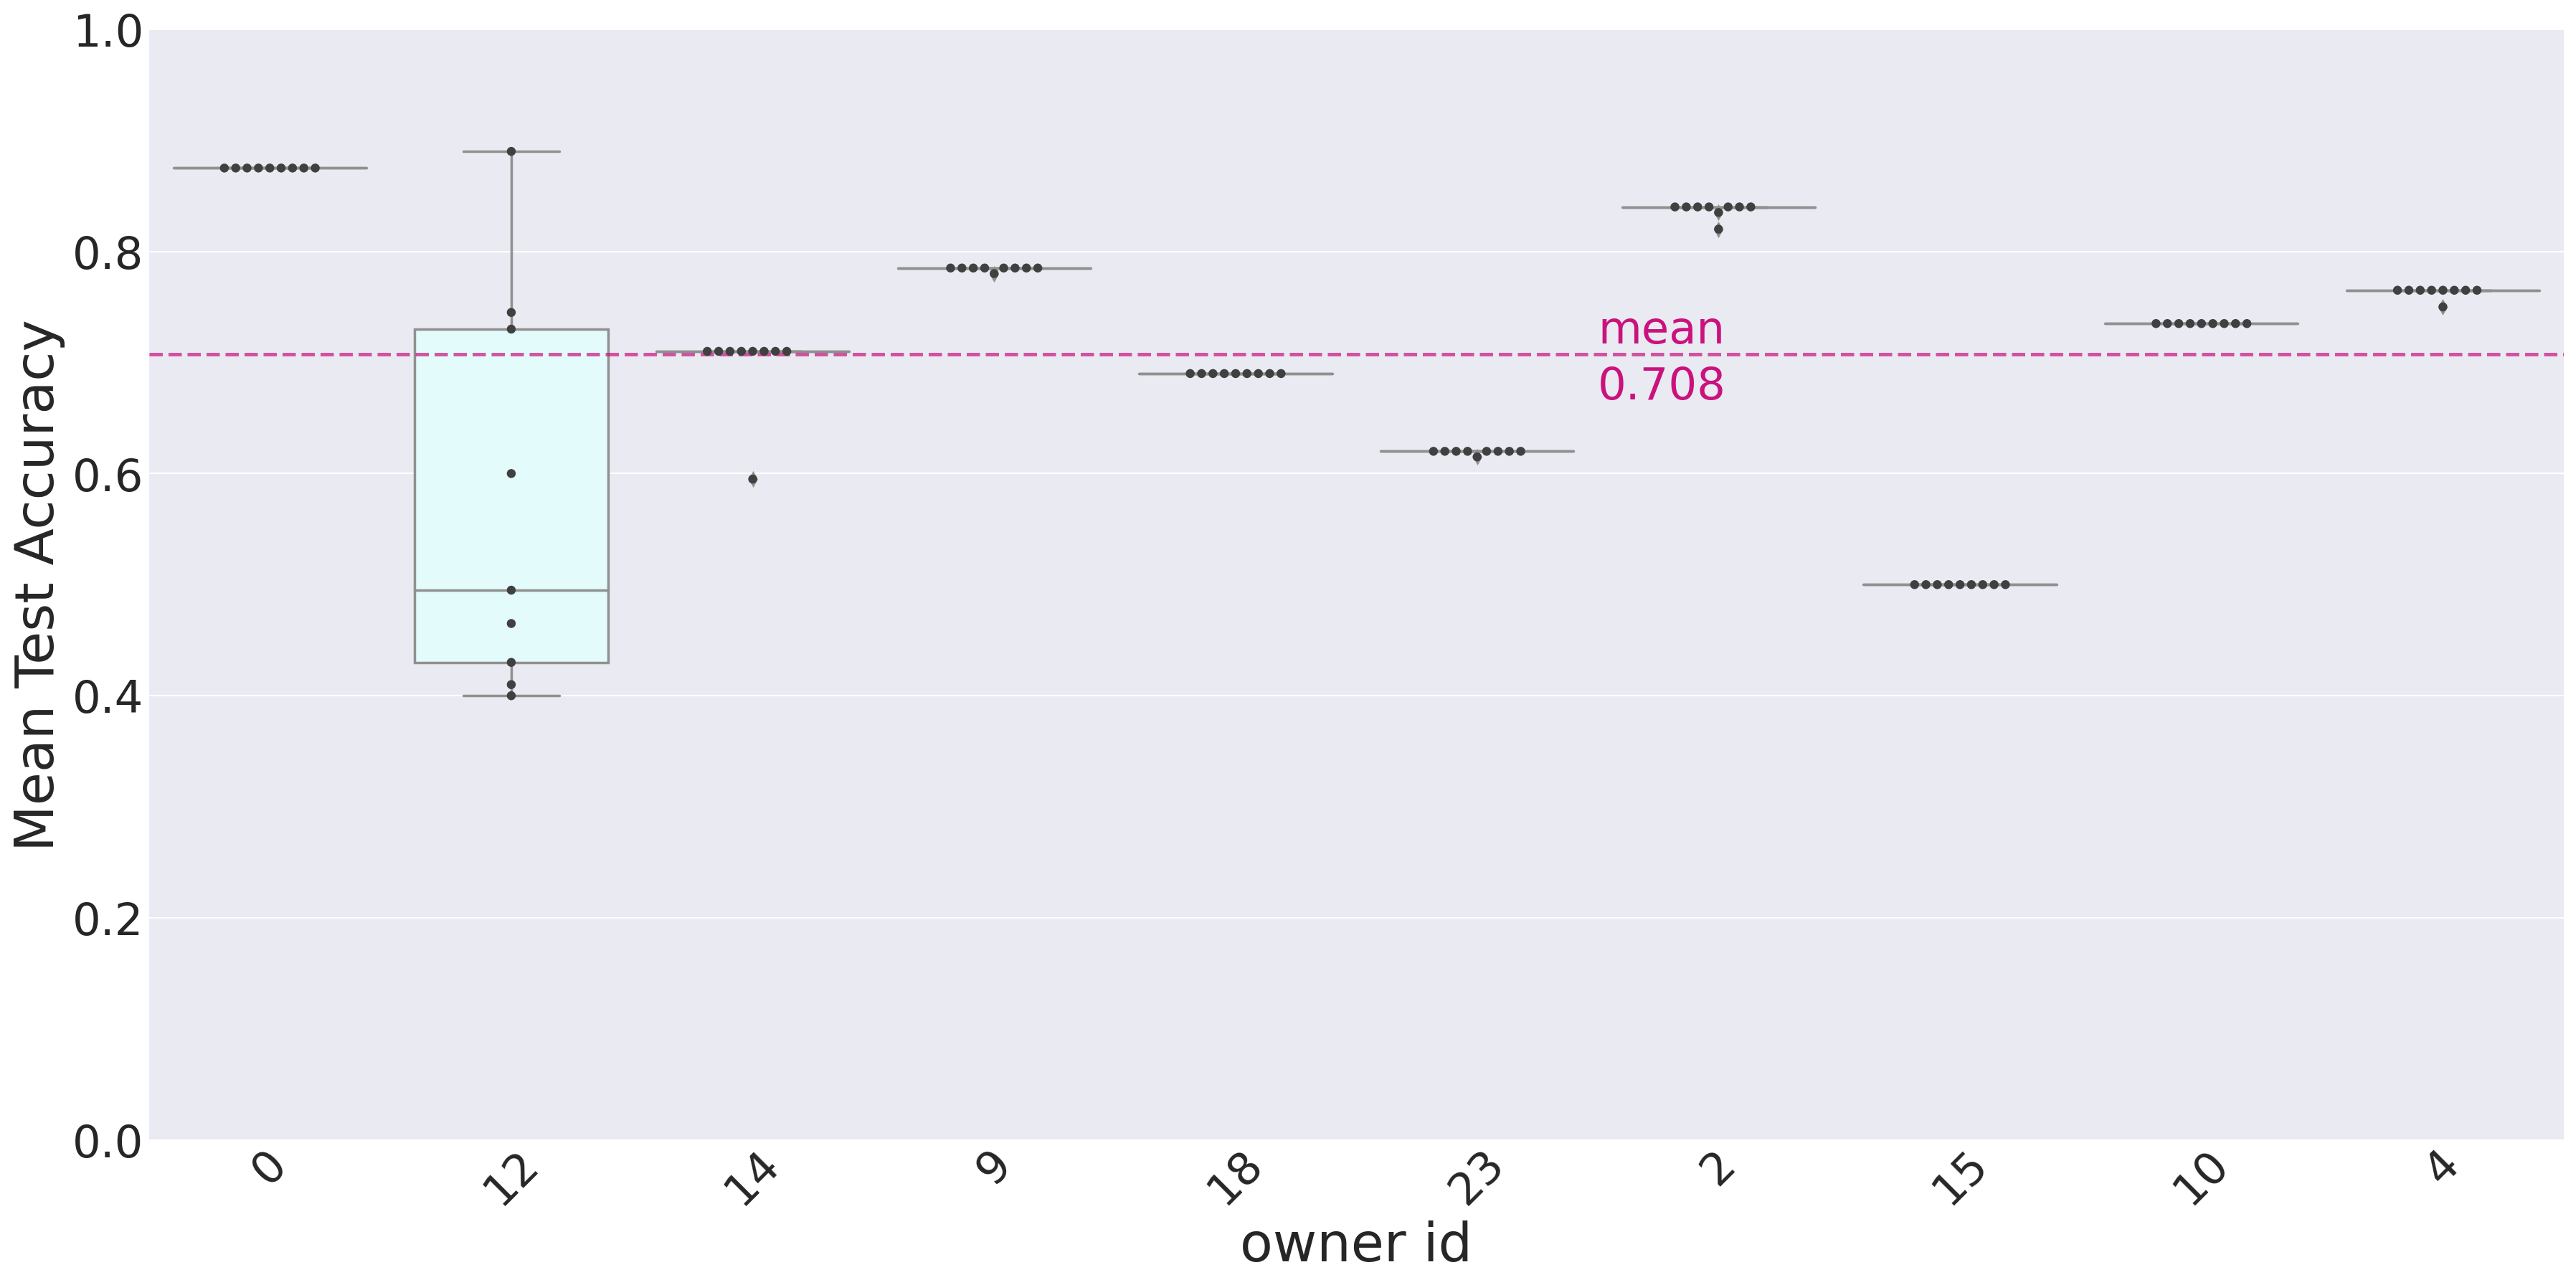

SEED: 567
--------------------SEED and CONSTANTS imported--------------------


In [66]:
utils_plot_acc_eer_dist_thesis(test_df_plot, 'Test EER', '', boxplot_color="lightcyan", save_file_name="WACA-OCSVM-750-Test_EER.svg")
utils_plot_acc_eer_dist_thesis(test_df_plot, 'Test Accuracy', '', boxplot_color="lightcyan", save_file_name="WACA-OCSVM-750-Test_Acc.svg")
%run ./SEED-CONSTANTS.ipynb


0.3437499308804177


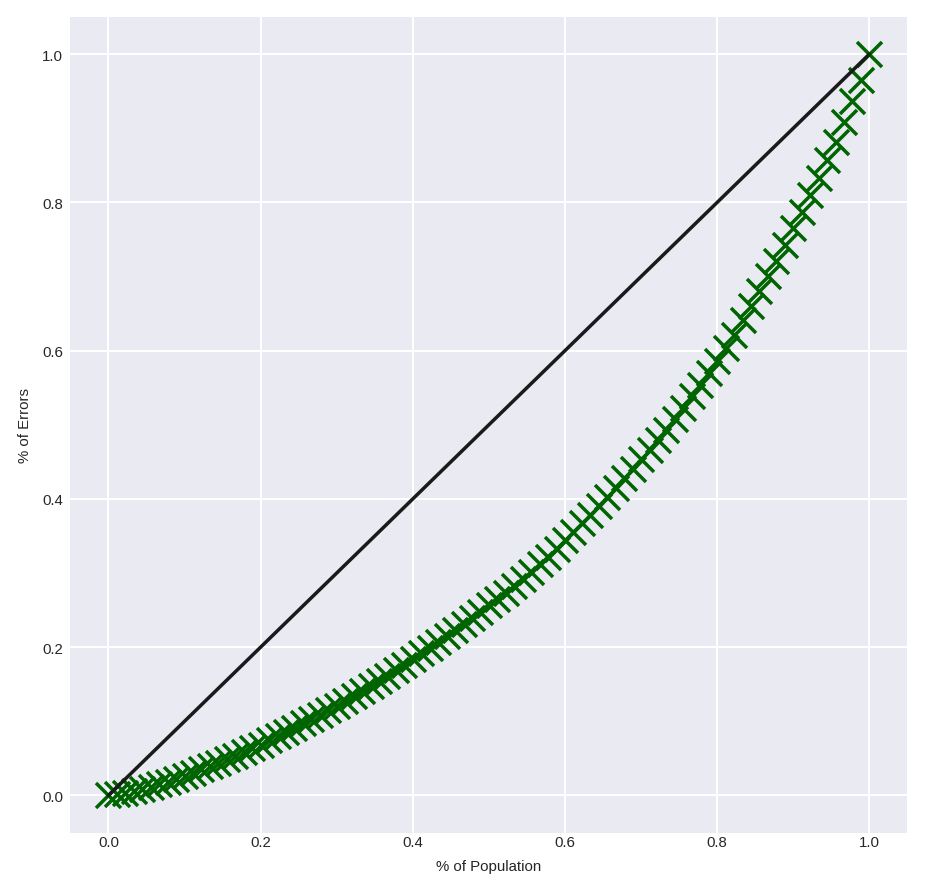

In [477]:
print(gini(test_df_plot['Test EER'].to_numpy()))
lorenz_curve(test_df_plot['Test EER'].to_numpy())